# Different ML for  SSP Prediction

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import pickle

In [3]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

c:\Users\marti\Desktop\data\hw_extra


## Load cmip6 drivers

In [4]:
import tensorflow as tf
import os
import numpy as np
import random
import keras
import xarray as xr
SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    keras.utils.set_random_seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, GRU, Conv1D, Flatten, Reshape

In [5]:
from Predictions import (
    PredictionModel,
    SERA,
)
from indices import get_heatwaves_indices, transform_time_label

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load Data

### Drivers

In [6]:
path_drivers_ssp = "data/03_primary/drivers/dfs_dict_ssps.pickle"
with open(path_drivers_ssp, 'rb') as handle:
    cmip6_drivers_dfs = pickle.load(handle)

scenarios = list(cmip6_drivers_dfs["EC-Earth3"].keys())
cmip6_models = list(cmip6_drivers_dfs.keys())
print("Scenarios", scenarios)
print("Models", cmip6_models)

Scenarios ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
Models ['MPI-ESM1-2-HR', 'MRI-ESM2-0', 'GFDL-ESM4', 'EC-Earth3', 'MIROC6', 'AWI-CM-1-1-MR', 'INM-CM4-8', 'ensemble_mean']


In [7]:
path_drivers_historical = "data/03_primary/drivers/dfs_dict.pickle"
with open(path_drivers_historical, 'rb') as handle:
    historical_dfs = pickle.load(handle)

In [8]:
hws_chile = pd.read_csv("data/local_data/monthly/hws_chile_new_agg.csv")

hws_chile["time"] = pd.to_datetime(hws_chile["Unnamed: 0"],format='%Y-%m')
hws_chile.set_index('time', inplace=True)
hws_chile.drop(columns="Unnamed: 0", inplace=True)
indices_of_interest = list(hws_chile.columns)
# hws_chile = hws_chile[["hwn", "hwf", "hwd", "hwm", "hwa", "hwmeani"]]
hws_chile

hwn  hwf  hwd       hwm       hwa   hwmeand       hwi     hwmaxi   
time                                                                           
1971-01-01  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000   0.000000  \
1971-02-01  0.2  0.7  4.0  2.155206  4.498967  3.500000  1.508644   8.398446   
1971-03-01  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000   0.000000   
1971-04-01  0.2  0.6  3.0  3.185188  5.672930  3.000000  1.911113  13.762538   
1971-05-01  0.1  0.3  3.0  5.556710  9.012540  3.000000  1.667013  16.670130   
...         ...  ...  ...       ...       ...       ...       ...        ...   
2023-08-01  0.3  1.0  4.0  2.786501  7.586745  3.333333  2.786501  13.359577   
2023-09-01  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000   0.000000   
2023-10-01  0.1  0.3  3.0  0.627372  0.775687  3.000000  0.188212   1.882117   
2023-11-01  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000   0.000000   
2023-12-01  0.1  0.6  6.0  0.772522  1.636048  6.000000  0.463513   4.635133   

              hwmeani  
time                   
1971-01-01   0.000000  
1971-02-01   7.543220  
1971-03-01   0.000000  
1971-04-01   9.555565  
1971-05-01  16.670130  
...               ...  
2023-08-01   9.288335  
2023-09-01   0.000000  
2023-10-01   1.882117  
2023-11-01   0.000000  
2023-12-01   4.635133  

[636 rows x 9 columns]

### Station Detection

In [9]:
path_stations_detection = "data/03_primary/events/cmip6/"
stat_list = [
    "330007",
    "330020",
    "330030",
    "340031",
    "360011",
    "360019",
    "380013",
    "390006",
    "400009",
    "410005",
]
hw_model_scenario_station_df = {
    model: {
        scenario: {
            station: xr.open_dataset(f"{path_stations_detection}/{model}/{scenario}/station_detection/{station}/default.nc").to_dataframe() for station in stat_list
        } for scenario in scenarios
    } for model in cmip6_models[:-1]
}

In [10]:
hws_chile_model_scenario_yearly = {}
indices = ("hwn", "hwf", "hwd", "hwm", "hwa", "hwmeand", "hwi", "hwmaxi", "hwmeani")
for model_name, dict_scenarios in hw_model_scenario_station_df.items():
    scenario_stat_hws = {}
    for scenario, dict_stations in dict_scenarios.items():
        stations_indices = {}
        if scenario == "historical":
            target_years = (1970, 2014)
        else:
            target_years = (2015, 2100)

        # Get yearly indices for 10 stations
        for station_name, hw in dict_stations.items():
            stations_indices[station_name] = get_heatwaves_indices(hw, target_years, time_scale="year")

        # Concat stations indices
        hws_all_stats = pd.concat(list(stations_indices.values()), axis=1)
        hws_chile_df = pd.DataFrame(columns=indices, index=hws_all_stats.index)

        for index in indices:
            if index in ["hwn", "hwf", "hwi"]:
                hws_chile_df[index] = hws_all_stats[index].mean(axis=1)
            elif index in ["hwd", "hwa", "hwmaxi"]:
                hws_chile_df[index] = hws_all_stats[index].max(axis=1)
            elif index == "hwmeand":
                hws_chile_df[index] = hws_all_stats["hwf"].sum(axis=1) / hws_all_stats["hwn"].sum(axis=1)
            elif index == "hwm":
                hws_chile_df[index] = hws_all_stats["hwi"].sum(axis=1) / hws_all_stats["hwf"].sum(axis=1)
            elif index == "hwmeani":
                hws_chile_df[index] = hws_all_stats["hwi"].sum(axis=1) / hws_all_stats["hwn"].sum(axis=1)

        hws_chile_df = hws_chile_df.fillna(0.0)
        scenario_stat_hws[scenario] = hws_chile_df
    hws_chile_model_scenario_yearly[model_name] = scenario_stat_hws

# Labels by mathematical relationship

## hwf, hwm, hwi 

In [11]:
indices_of_interest = ["hwf", "hwm", "hwi"]
hws_labels = hws_chile[indices_of_interest]
era5_df = pd.concat((historical_dfs["ERA5"],hws_labels),axis=1)

In [12]:
meteochile_yearly = transform_time_label(era5_df[indices_of_interest], "year")

In [ ]:
bounds = (-1.1692892810242344, -0.30647585455315646, 3.0, 6.499969486244418)
loss_fn=SERA(bounds=bounds,T=100, initial_weight=0.1, fn="piecewise2")
models_scenario_predicted = {model: {} for model in cmip6_drivers_dfs.keys()}
seasons_label_scalers = {}
df_pred_train = pd.DataFrame(columns=indices_of_interest, index=era5_df.index)

for i in range(1,13):
    df_season = era5_df[era5_df.index.month==i]
    cnn_rnn_model = Sequential([
            Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(era5_df.columns) - len(indices_of_interest))),
            Reshape((1, 16)),  # Back to time dimension
            SimpleRNN(8, activation="tanh"),
            Dropout(0.1),
            Dense(len(indices_of_interest))
        ])
    pred = PredictionModel(df_season, i, indices_of_interest, cnn_rnn_model, name_regressor="CNNRNN16",loss_fn=loss_fn)
    seasons_label_scalers[i] = pred.label_scaler
    pred.compile_keras_model()
    
    y_train, y_pred_train = pred.train(5)
    df_pred_train.loc[df_season.index[:-5]] = pred.label_scaler.inverse_transform(y_pred_train)
    df_pred_train.sort_index(inplace=True)
    for name, scenarios_df in cmip6_drivers_dfs.items():
        for scenario in scenarios:
            if i==1:
                models_scenario_predicted[name][scenario] = pd.DataFrame()
            df_target = scenarios_df[scenario][scenarios_df[scenario].index.month==i]
            if scenario == "historical":
                df_target = df_target[(df_target.index.year >=1970) & (df_target.index.year <= 2014)]
            else:
                df_target = df_target[(df_target.index.year >=2015) & (df_target.index.year <= 2100)]
            # df_target[indices_of_interest] = df_season[indices_of_interest]
            # Normalize cmip6 features for machine input
            target = pred.scaler_X.transform(df_target[pred.scaler_X.feature_names_in_])
            # Reshape for keras and predict
            predicted_normalized = pred.regressor.predict(pred.reshape_for_keras(target))
            # Transform back to original range
            predicted_real = pred.label_scaler.inverse_transform(predicted_normalized)
            predicted = pd.DataFrame(predicted_real).rename(columns={i: label for i,label in enumerate(indices_of_interest)})
            predicted["Date"] = df_target.index
            predicted.set_index("Date",inplace=True)
            models_scenario_predicted[name][scenario] = pd.concat((models_scenario_predicted[name][scenario],predicted),axis=0)
        
df_pred_train = df_pred_train.dropna()
df_pred_train = df_pred_train.astype(np.number)


### Build Mean Prediction of all models

In [14]:
mean_scenario = {}
for scenario in scenarios:
    temp_df = pd.DataFrame()
    for name, model_scenario in models_scenario_predicted.items():
        temp_df = pd.concat((temp_df, model_scenario[scenario]), axis=1)
        
    mean_scenario[scenario] = pd.DataFrame(columns=models_scenario_predicted["EC-Earth3"][scenario].columns,index=model_scenario[scenario].index)
    for col in np.unique(temp_df.columns):
        mean_scenario[scenario][col] = temp_df[col].mean(axis=1)
models_scenario_predicted["mean"] = mean_scenario

for scenario in scenarios:
    models_scenario_predicted["mean"][scenario] = models_scenario_predicted["mean"][scenario].astype(np.float64)
models_predicted_yearly = {model: {} for model in models_scenario_predicted.keys()}
models_predicted_decadal = {model: {} for model in models_scenario_predicted.keys()}

for name, model_scenario in models_scenario_predicted.items():
    for scenario, df in model_scenario.items():
        
        models_predicted_yearly[name][scenario] = transform_time_label(df, "year")
        models_predicted_decadal[name][scenario] = transform_time_label(df, "decade")

pred_train_yearly = transform_time_label(df_pred_train, "year")

### Mean of predicted Models

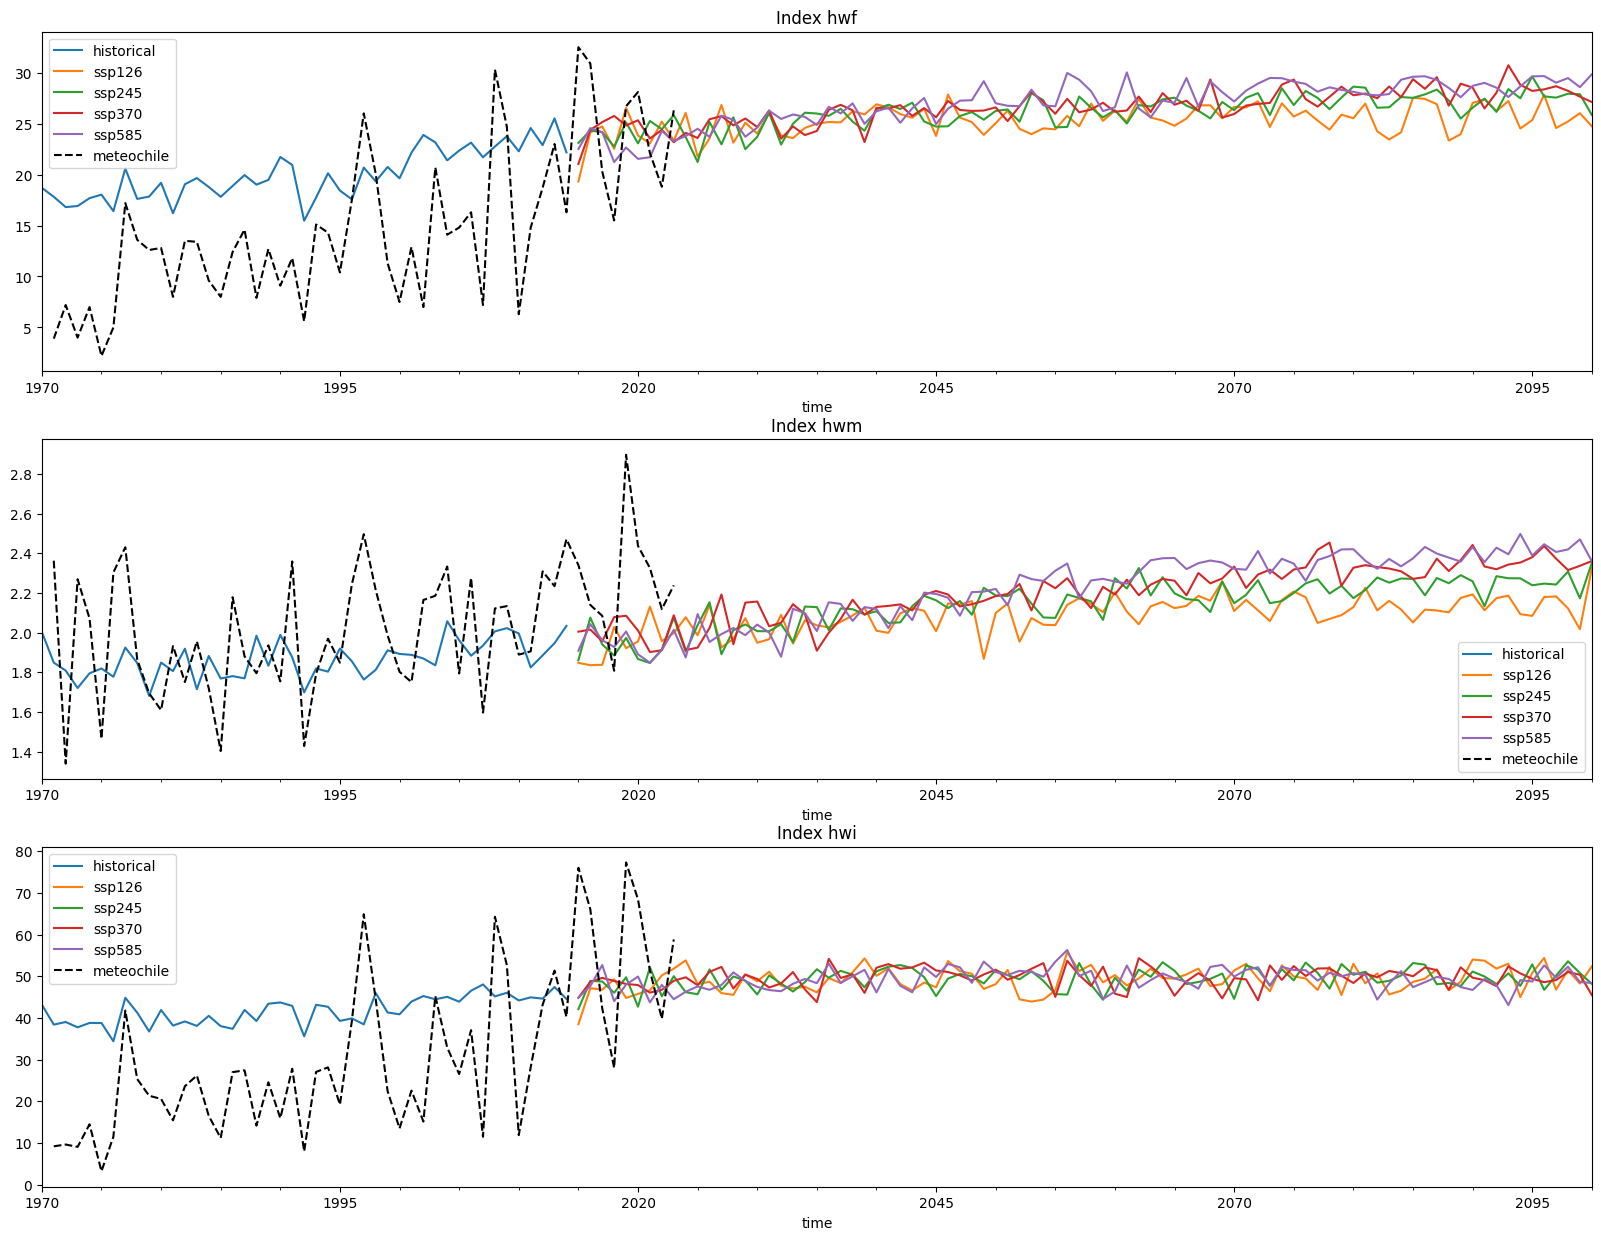

In [15]:
model = "mean"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 15))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    axs[i].set_title(f"Index {index}")

### Mean Predictions vs Mean Detection

In [16]:
hw_mean_scenario = {}
models = list(hws_chile_model_scenario_yearly.keys())
for scenario in scenarios:
    
    all_models = pd.concat([hws_chile_model_scenario_yearly[model][scenario] for model in models], axis=1)
    df_mean_scenario = pd.DataFrame(columns=indices, index=hws_chile_model_scenario_yearly["EC-Earth3"][scenario].index)
    for index in indices:
        df_mean_scenario[index] = all_models[index].mean(axis=1)

    hw_mean_scenario[scenario] = df_mean_scenario

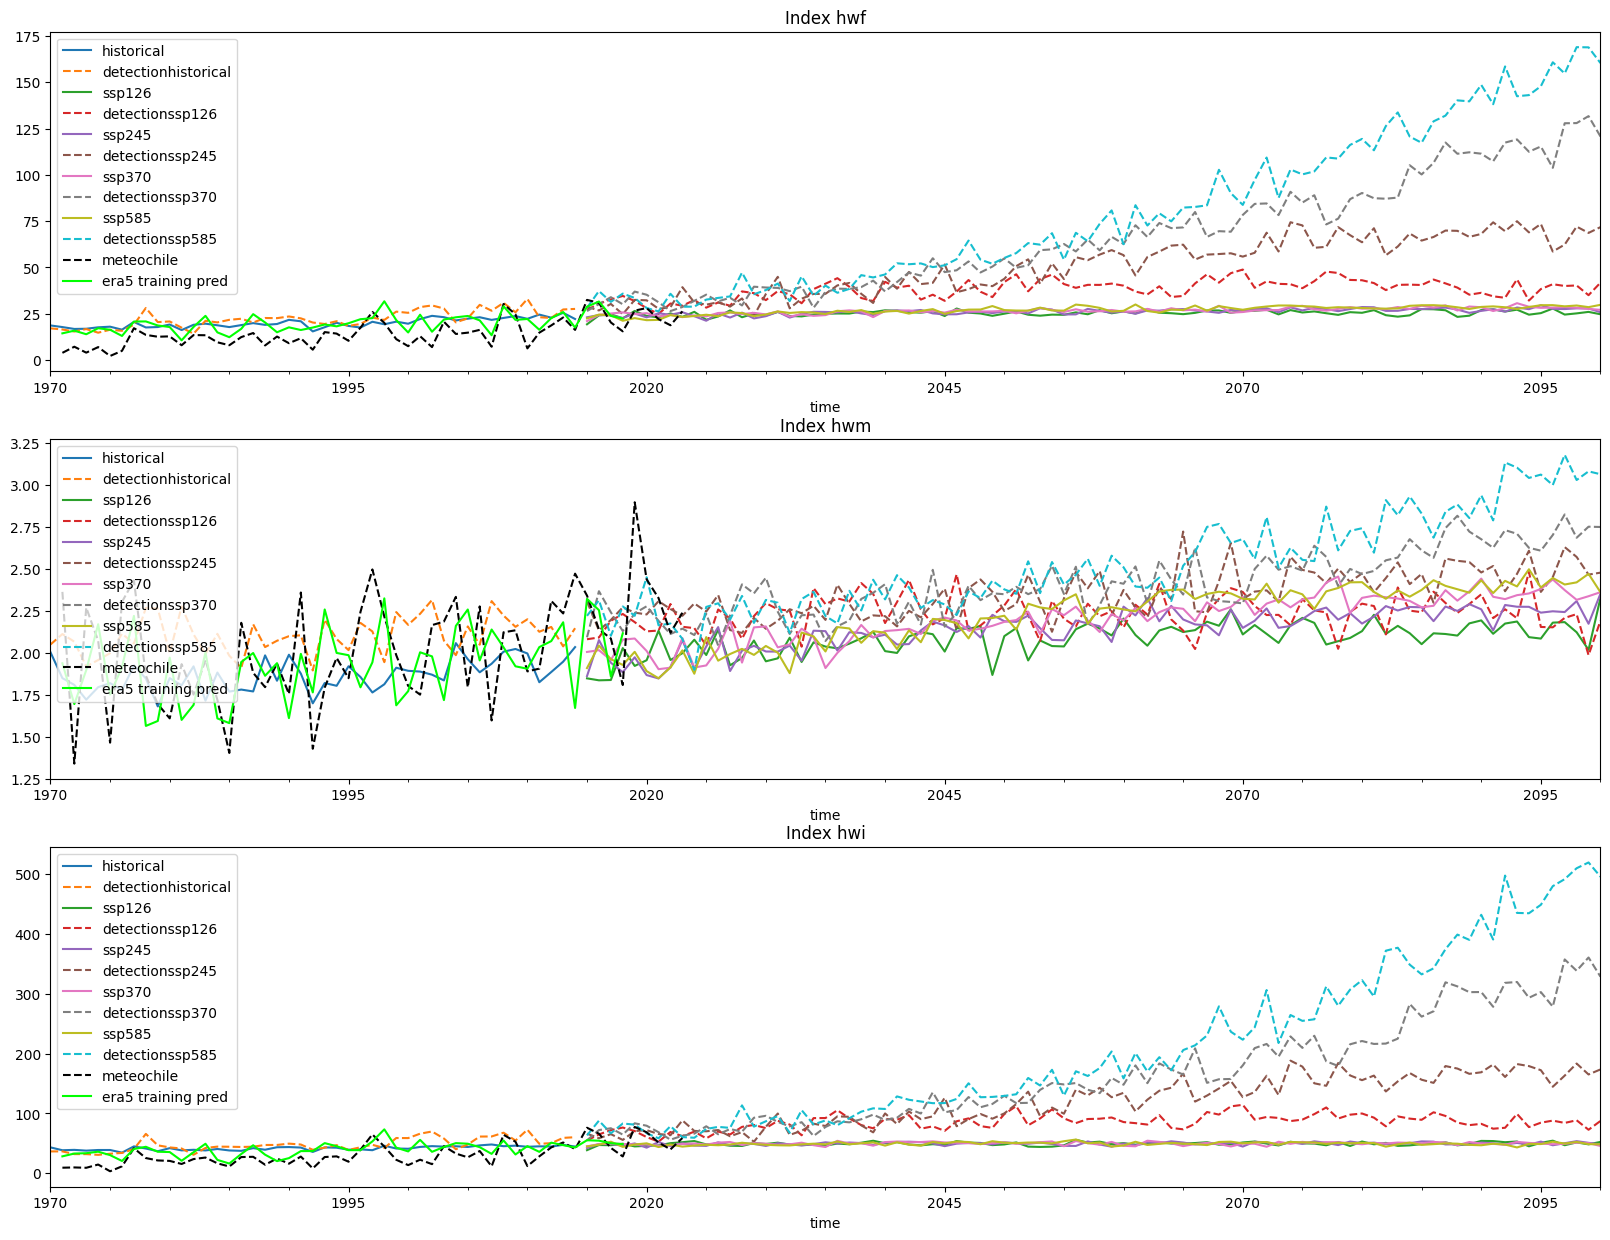

In [17]:
model = "mean"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 15))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
        values = hw_mean_scenario[scenario][index].values
        new_df = pd.DataFrame(values, columns=[index], index=df.index)
        # axs[i].plot(df.index, values, label=f"detection {scenario}")
        new_df.plot(y=index, ax=axs[i], label=f"detection{scenario}", linestyle="--")
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")
    axs[i].legend()

### Mathematical Validation

In [18]:
def compare_relationships(models_dict):
    """
    Compare mathematical relationships between heatwave indices for each model.

    Parameters
    ----------
    models_dict : dict
        Dictionary of {model_name: dataframe} containing indices.

    Returns
    -------
    dict
        Dictionary {model_name: dataframe} with comparison results.
    """
    tol = 1e-6

    results = {model : {} for model in models_dict.keys()}

    for model, dict in models_dict.items():
        for scenario, df in dict.items():
            comp_df = pd.DataFrame(index=df.index)

            # Expected values
            exp_hwi = df["hwm"] * df["hwf"]
            # exp_hwmeand   = df["hwf"] / df["hwn"]
            # exp_hwmeani   = df["hwi"] / df["hwn"]

            # Relative differences
            comp_df["rel_diff_hwi"] = (df["hwi"] - exp_hwi) / (exp_hwi + tol)
            # comp_df["rel_diff_hwmeand"]   = (df["hwmeand"]   - exp_hwmeand)   / (exp_hwmeand   + tol)
            # comp_df["rel_diff_hwmeani"]   = (df["hwmeani"]   - exp_hwmeani)   / (exp_hwmeani   + tol)

            # Inequalities → booleans
            # comp_df["hwd_ge_hwmd"] = df["hwd"] >= df["hwmeand"]
            # comp_df["hwa_ge_hwm"]  = df["hwa"] >= df["hwm"]
            # comp_df["hwmaxi_ge_hwmeani"]  = df["hwmaxi"] >= df["hwmeani"]
            # comp_df["hwmi_ge_hwmeani"]  = df["hwi"] >= df["hwmeani"]
            results[model][scenario] = comp_df

    return results


In [19]:
yearly_checks = compare_relationships(models_predicted_yearly)

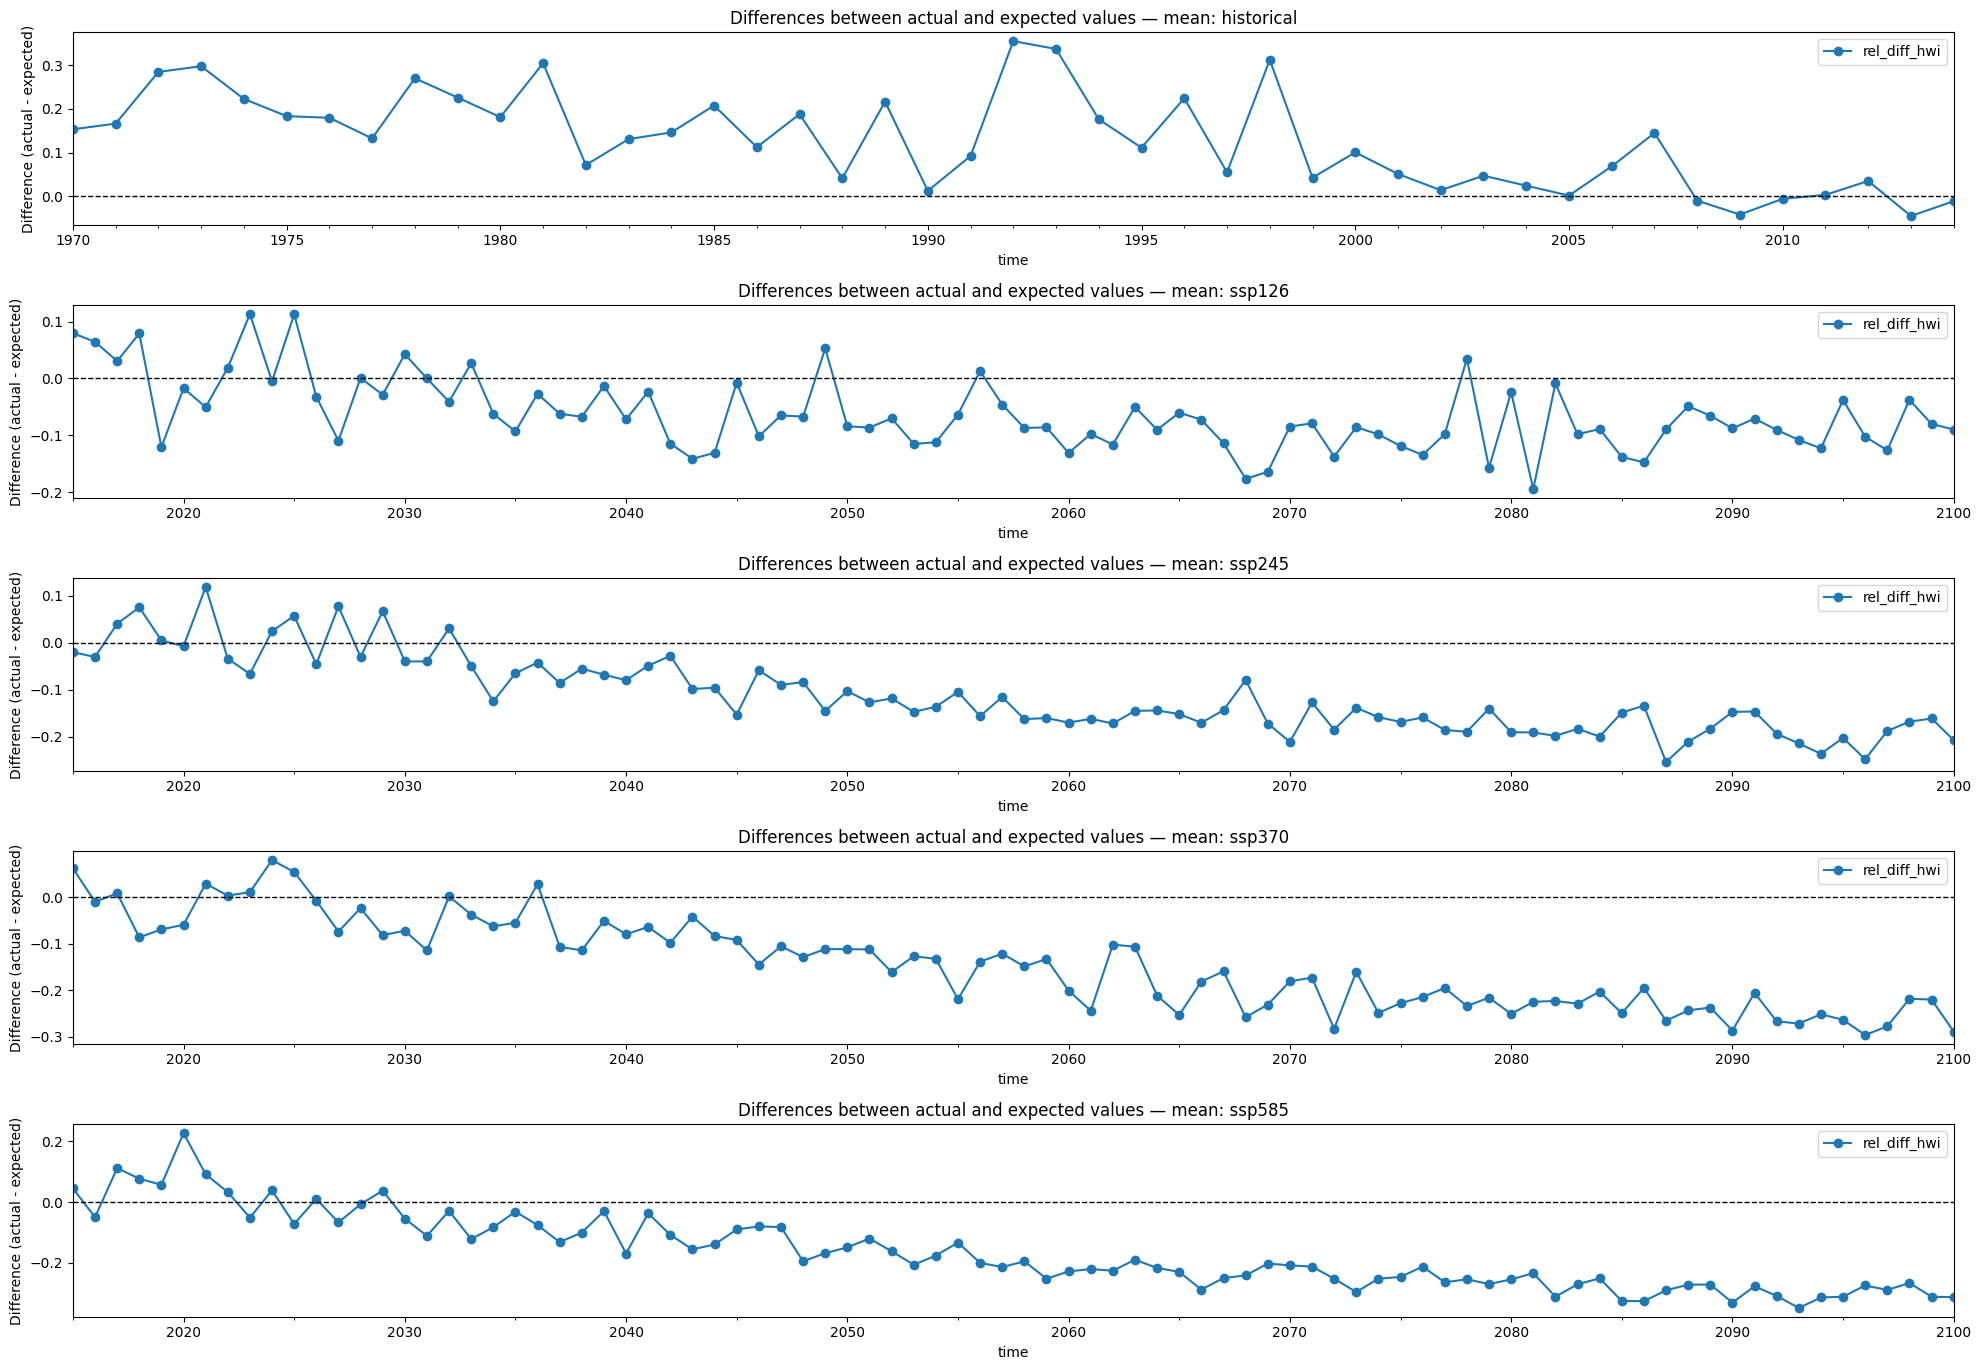

In [20]:
def plot_differences(model_name, checks_dict):

    fig, ax = plt.subplots(len(scenarios), figsize=(20, 15))
    for i,scenario in enumerate(scenarios):
        df = checks_dict[model_name][scenario]
        df[["rel_diff_hwi"]].plot(ax=ax[i], marker="o")
        ax[i].axhline(0, color="black", linestyle="--", linewidth=1)
        ax[i].set_title(f"Differences between actual and expected values — {model_name}: {scenario}")
        ax[i].set_ylabel("Difference (actual - expected)")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
    plt.show()

# Example: yearly
plot_differences("mean", yearly_checks)


## hwmeand, hwf, hwn

In [21]:
indices_of_interest = ["hwn", "hwf", "hwmeand"]
hws_labels = hws_chile[indices_of_interest]
era5_df = pd.concat((historical_dfs["ERA5"],hws_labels),axis=1)

In [22]:
meteochile_yearly = transform_time_label(era5_df[indices_of_interest], "year")

In [ ]:
bounds = (-1.1692892810242344, -0.30647585455315646, 3.0, 6.499969486244418)
loss_fn=SERA(bounds=bounds,T=100, initial_weight=0.1, fn="piecewise2")
models_scenario_predicted = {model: {} for model in cmip6_drivers_dfs.keys()}
seasons_label_scalers = {}
df_pred_train = pd.DataFrame(columns=indices_of_interest, index=era5_df.index)

for i in range(1,13):
    df_season = era5_df[era5_df.index.month==i]
    cnn_rnn_model = Sequential([
            Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(era5_df.columns) - len(indices_of_interest))),
            Reshape((1, 16)),  # Back to time dimension
            SimpleRNN(8, activation="tanh"),
            Dropout(0.1),
            Dense(len(indices_of_interest))
        ])
    pred = PredictionModel(df_season, i, indices_of_interest, cnn_rnn_model, name_regressor="CNNRNN16",loss_fn=loss_fn)
    seasons_label_scalers[i] = pred.label_scaler
    pred.compile_keras_model()
    
    y_train, y_pred_train = pred.train(5)
    df_pred_train.loc[df_season.index[:-5]] = pred.label_scaler.inverse_transform(y_pred_train)
    df_pred_train.sort_index(inplace=True)
    for name, scenarios_df in cmip6_drivers_dfs.items():
        for scenario in scenarios:
            if i==1:
                models_scenario_predicted[name][scenario] = pd.DataFrame()
            df_target = scenarios_df[scenario][scenarios_df[scenario].index.month==i]
            if scenario == "historical":
                df_target = df_target[(df_target.index.year >=1970) & (df_target.index.year <= 2014)]
            else:
                df_target = df_target[(df_target.index.year >=2015) & (df_target.index.year <= 2100)]
            # df_target[indices_of_interest] = df_season[indices_of_interest]
            # Normalize cmip6 features for machine input
            target = pred.scaler_X.transform(df_target[pred.scaler_X.feature_names_in_])
            # Reshape for keras and predict
            predicted_normalized = pred.regressor.predict(pred.reshape_for_keras(target))
            # Transform back to original range
            predicted_real = pred.label_scaler.inverse_transform(predicted_normalized)
            predicted = pd.DataFrame(predicted_real).rename(columns={i: label for i,label in enumerate(indices_of_interest)})
            predicted["Date"] = df_target.index
            predicted.set_index("Date",inplace=True)
            models_scenario_predicted[name][scenario] = pd.concat((models_scenario_predicted[name][scenario],predicted),axis=0)
        
df_pred_train = df_pred_train.dropna()
df_pred_train = df_pred_train.astype(np.number)


### Build Mean Prediction of all models

In [24]:
mean_scenario = {}
for scenario in scenarios:
    temp_df = pd.DataFrame()
    for name, model_scenario in models_scenario_predicted.items():
        temp_df = pd.concat((temp_df, model_scenario[scenario]), axis=1)
        
    mean_scenario[scenario] = pd.DataFrame(columns=models_scenario_predicted["EC-Earth3"][scenario].columns,index=model_scenario[scenario].index)
    for col in np.unique(temp_df.columns):
        mean_scenario[scenario][col] = temp_df[col].mean(axis=1)
models_scenario_predicted["mean"] = mean_scenario

for scenario in scenarios:
    models_scenario_predicted["mean"][scenario] = models_scenario_predicted["mean"][scenario].astype(np.float64)
models_predicted_yearly = {model: {} for model in models_scenario_predicted.keys()}
models_predicted_decadal = {model: {} for model in models_scenario_predicted.keys()}

for name, model_scenario in models_scenario_predicted.items():
    for scenario, df in model_scenario.items():
        
        models_predicted_yearly[name][scenario] = transform_time_label(df, "year")
        models_predicted_decadal[name][scenario] = transform_time_label(df, "decade")

pred_train_yearly = transform_time_label(df_pred_train, "year")

### Mean of predicted Models

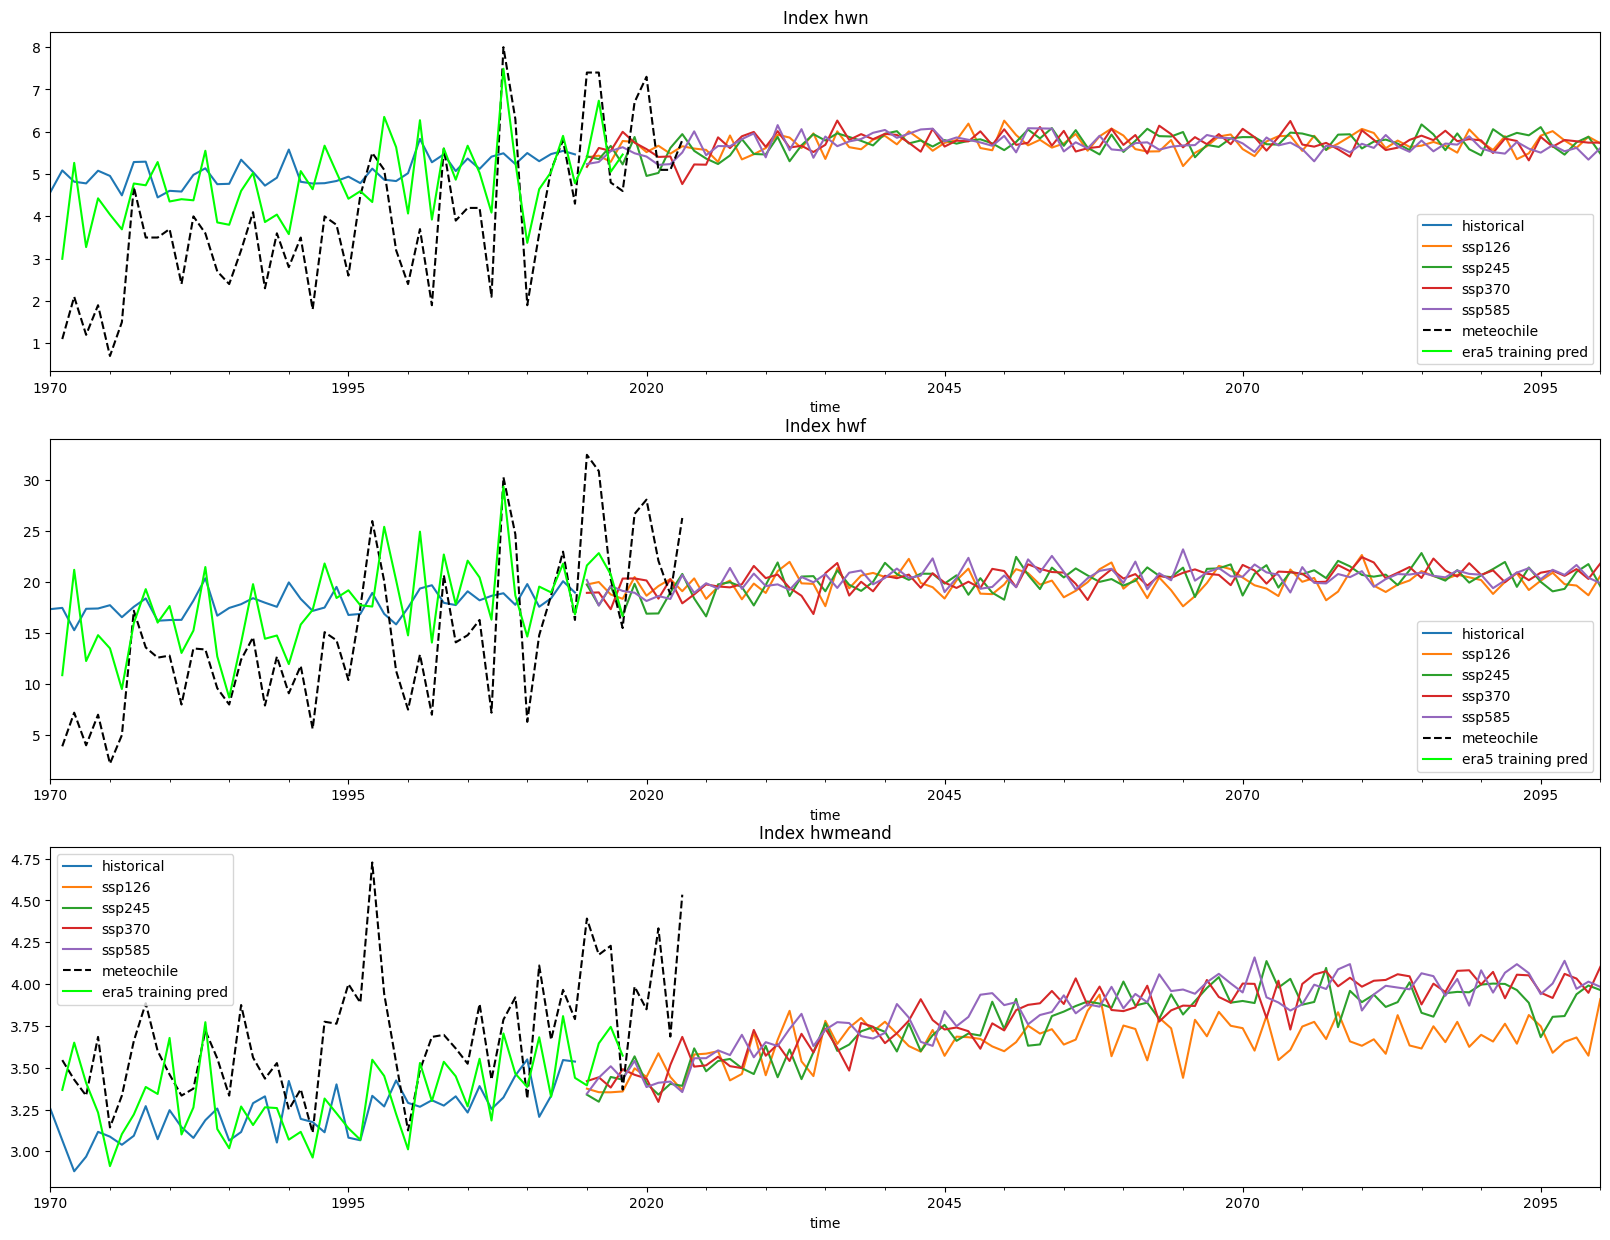

In [25]:
model = "mean"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 15))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")

### Mean Predictions vs Mean Detection

In [26]:
hw_mean_scenario = {}
models = list(hws_chile_model_scenario_yearly.keys())
for scenario in scenarios:
    
    all_models = pd.concat([hws_chile_model_scenario_yearly[model][scenario] for model in models], axis=1)
    df_mean_scenario = pd.DataFrame(columns=indices, index=hws_chile_model_scenario_yearly["EC-Earth3"][scenario].index)
    for index in indices:
        df_mean_scenario[index] = all_models[index].mean(axis=1)

    hw_mean_scenario[scenario] = df_mean_scenario

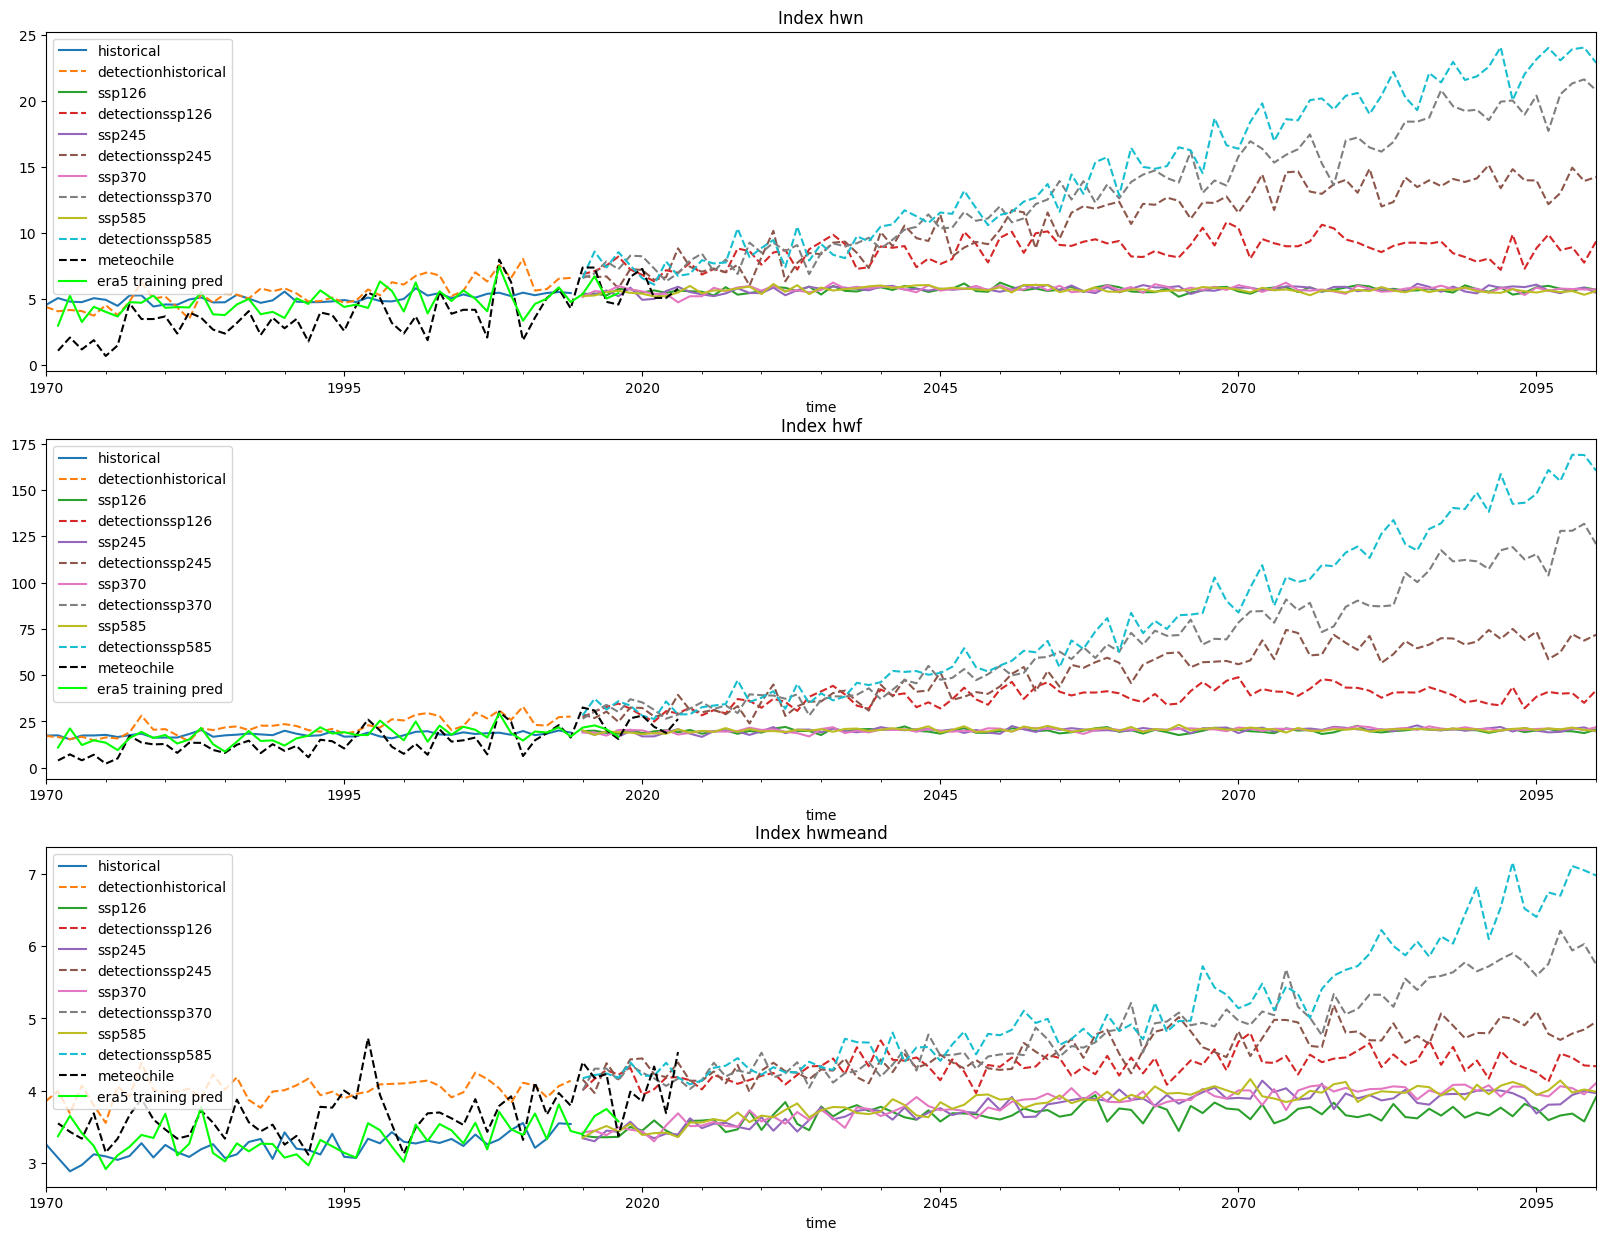

In [27]:
model = "mean"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 15))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
        values = hw_mean_scenario[scenario][index].values
        new_df = pd.DataFrame(values, columns=[index], index=df.index)
        # axs[i].plot(df.index, values, label=f"detection {scenario}")
        new_df.plot(y=index, ax=axs[i], label=f"detection{scenario}", linestyle="--")
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")
    axs[i].legend()

### Mathematical Validation

In [28]:
def compare_relationships(models_dict):
    """
    Compare mathematical relationships between heatwave indices for each model.

    Parameters
    ----------
    models_dict : dict
        Dictionary of {model_name: dataframe} containing indices.

    Returns
    -------
    dict
        Dictionary {model_name: dataframe} with comparison results.
    """
    tol = 1e-6

    results = {model : {} for model in models_dict.keys()}

    for model, dict in models_dict.items():
        for scenario, df in dict.items():
            comp_df = pd.DataFrame(index=df.index)

            # Expected values
            # exp_hwi = df["hwm"] * df["hwf"]
            exp_hwmeand   = df["hwf"] / df["hwn"]
            # exp_hwmeani   = df["hwi"] / df["hwn"]

            # Relative differences
            # comp_df["rel_diff_hwi"] = (df["hwi"] - exp_hwi) / (exp_hwi + tol)
            comp_df["rel_diff_hwmeand"]   = (df["hwmeand"]   - exp_hwmeand)   / (exp_hwmeand   + tol)
            # comp_df["rel_diff_hwmeani"]   = (df["hwmeani"]   - exp_hwmeani)   / (exp_hwmeani   + tol)

            # Inequalities → booleans
            # comp_df["hwd_ge_hwmd"] = df["hwd"] >= df["hwmeand"]
            # comp_df["hwa_ge_hwm"]  = df["hwa"] >= df["hwm"]
            # comp_df["hwmaxi_ge_hwmeani"]  = df["hwmaxi"] >= df["hwmeani"]
            # comp_df["hwmi_ge_hwmeani"]  = df["hwi"] >= df["hwmeani"]
            results[model][scenario] = comp_df

    return results


In [29]:
yearly_checks = compare_relationships(models_predicted_yearly)

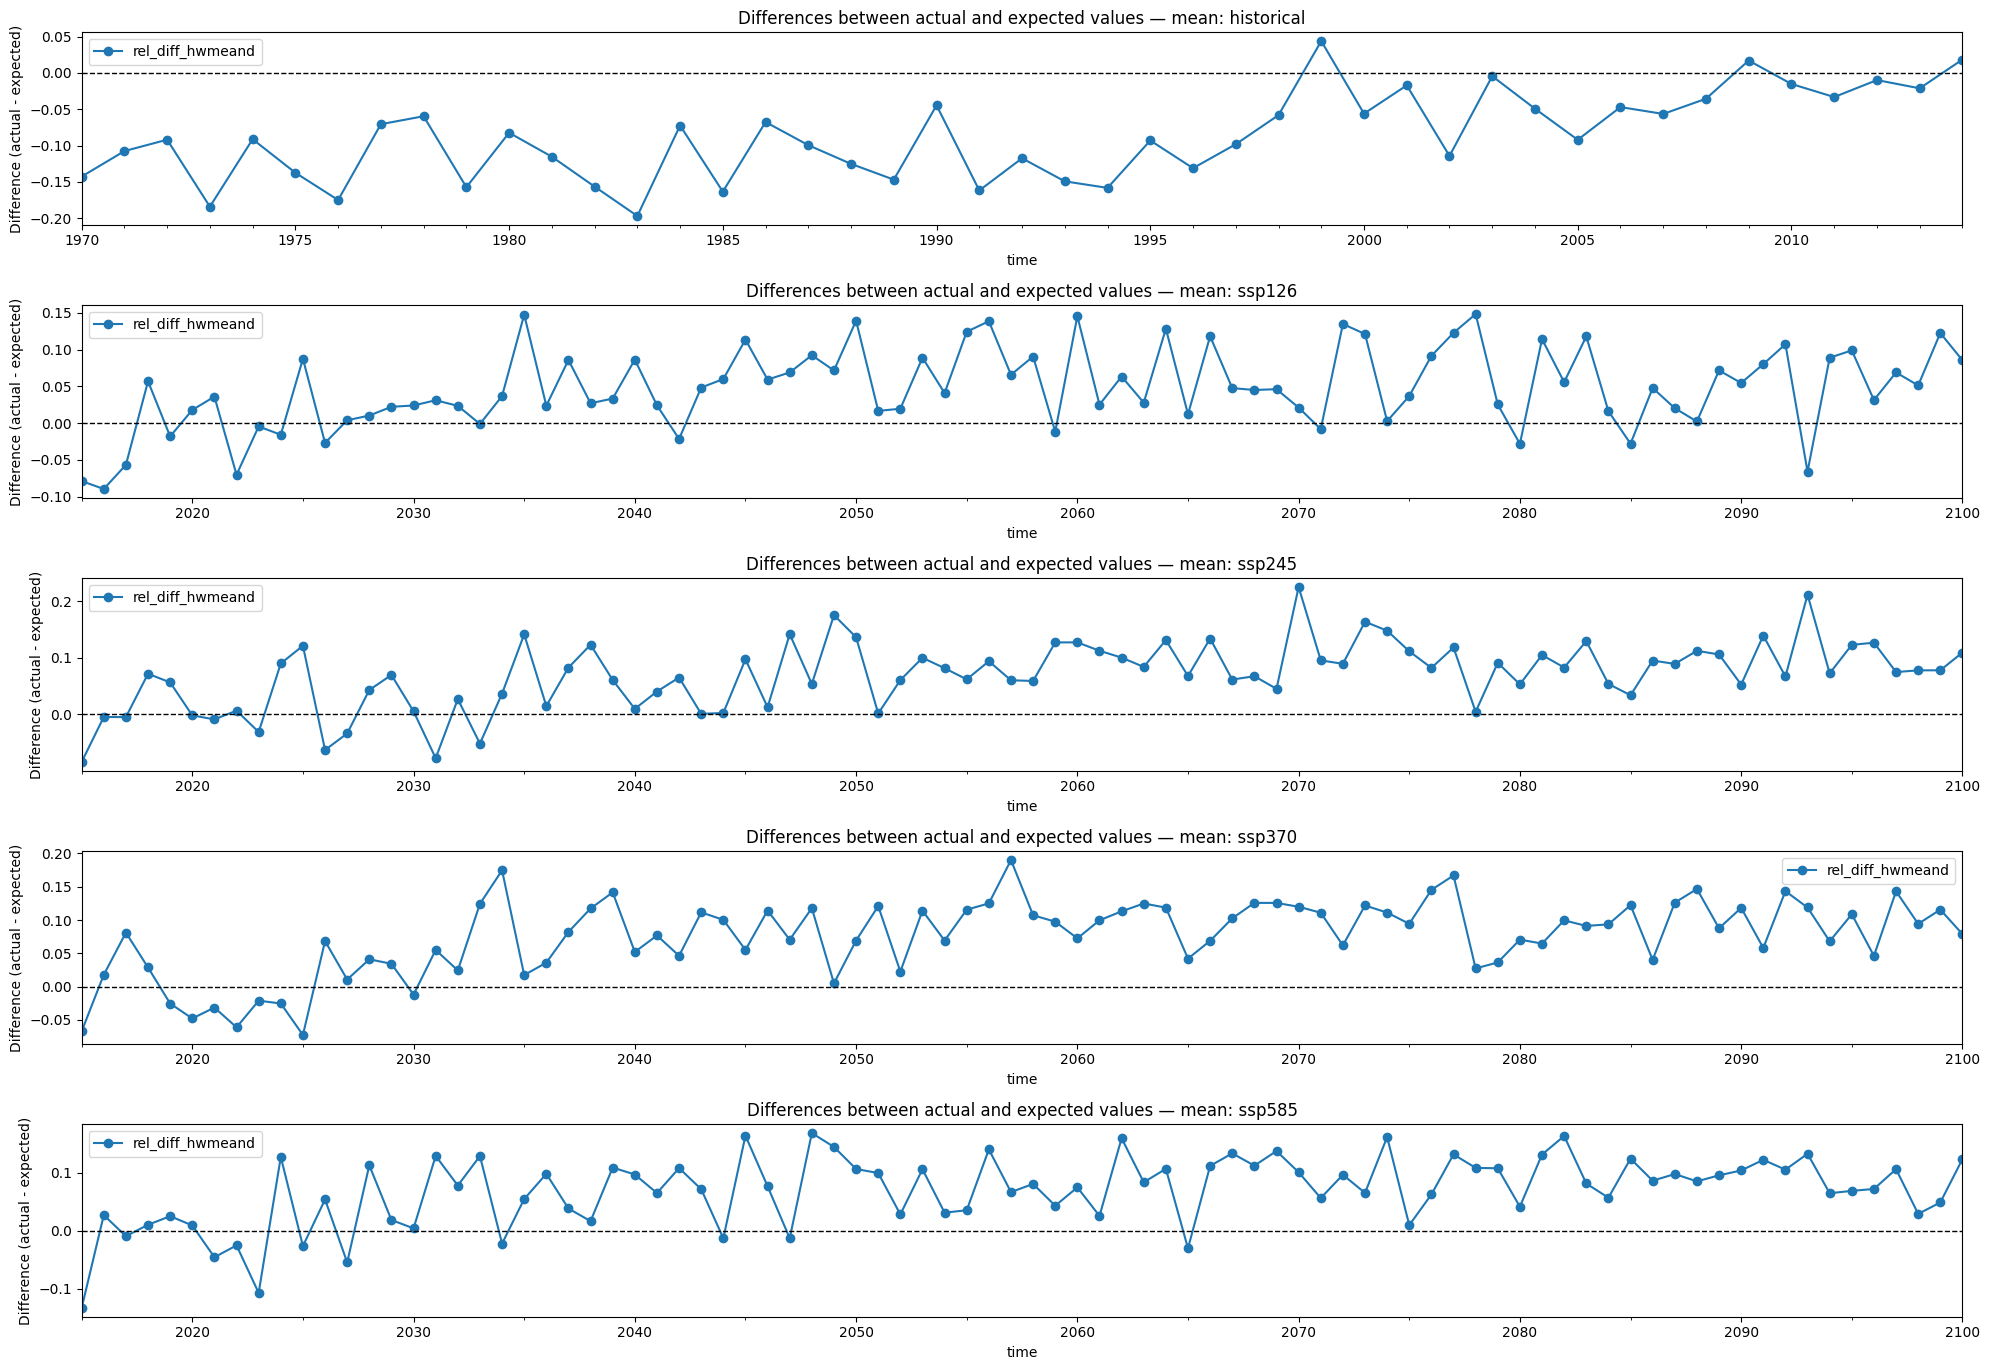

In [30]:
def plot_differences(model_name, checks_dict):

    fig, ax = plt.subplots(len(scenarios), figsize=(20, 15))
    for i,scenario in enumerate(scenarios):
        df = checks_dict[model_name][scenario]
        df[["rel_diff_hwmeand"]].plot(ax=ax[i], marker="o")
        ax[i].axhline(0, color="black", linestyle="--", linewidth=1)
        ax[i].set_title(f"Differences between actual and expected values — {model_name}: {scenario}")
        ax[i].set_ylabel("Difference (actual - expected)")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
    plt.show()

# Example: yearly
plot_differences("mean", yearly_checks)


## hwn, hwi, hwmeani

In [31]:
indices_of_interest = ["hwn", "hwi", "hwmeani"]
hws_labels = hws_chile[indices_of_interest]
era5_df = pd.concat((historical_dfs["ERA5"],hws_labels),axis=1)

In [32]:
meteochile_yearly = transform_time_label(era5_df[indices_of_interest], "year")

In [ ]:
bounds = (-1.1692892810242344, -0.30647585455315646, 3.0, 6.499969486244418)
loss_fn=SERA(bounds=bounds,T=100, initial_weight=0.1, fn="piecewise2")
models_scenario_predicted = {model: {} for model in cmip6_drivers_dfs.keys()}
seasons_label_scalers = {}
df_pred_train = pd.DataFrame(columns=indices_of_interest, index=era5_df.index)

for i in range(1,13):
    df_season = era5_df[era5_df.index.month==i]
    cnn_rnn_model = Sequential([
            Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(era5_df.columns) - len(indices_of_interest))),
            Reshape((1, 16)),  # Back to time dimension
            SimpleRNN(8, activation="tanh"),
            Dropout(0.1),
            Dense(len(indices_of_interest))
        ])
    pred = PredictionModel(df_season, i, indices_of_interest, cnn_rnn_model, name_regressor="CNNRNN16",loss_fn=loss_fn)
    seasons_label_scalers[i] = pred.label_scaler
    pred.compile_keras_model()
    
    y_train, y_pred_train = pred.train(5)
    df_pred_train.loc[df_season.index[:-5]] = pred.label_scaler.inverse_transform(y_pred_train)
    df_pred_train.sort_index(inplace=True)
    for name, scenarios_df in cmip6_drivers_dfs.items():
        for scenario in scenarios:
            if i==1:
                models_scenario_predicted[name][scenario] = pd.DataFrame()
            df_target = scenarios_df[scenario][scenarios_df[scenario].index.month==i]
            if scenario == "historical":
                df_target = df_target[(df_target.index.year >=1970) & (df_target.index.year <= 2014)]
            else:
                df_target = df_target[(df_target.index.year >=2015) & (df_target.index.year <= 2100)]
            # df_target[indices_of_interest] = df_season[indices_of_interest]
            # Normalize cmip6 features for machine input
            target = pred.scaler_X.transform(df_target[pred.scaler_X.feature_names_in_])
            # Reshape for keras and predict
            predicted_normalized = pred.regressor.predict(pred.reshape_for_keras(target))
            # Transform back to original range
            predicted_real = pred.label_scaler.inverse_transform(predicted_normalized)
            predicted = pd.DataFrame(predicted_real).rename(columns={i: label for i,label in enumerate(indices_of_interest)})
            predicted["Date"] = df_target.index
            predicted.set_index("Date",inplace=True)
            models_scenario_predicted[name][scenario] = pd.concat((models_scenario_predicted[name][scenario],predicted),axis=0)
        
df_pred_train = df_pred_train.dropna()
df_pred_train = df_pred_train.astype(np.number)


### Build Mean Prediction of all models

In [34]:
mean_scenario = {}
for scenario in scenarios:
    temp_df = pd.DataFrame()
    for name, model_scenario in models_scenario_predicted.items():
        temp_df = pd.concat((temp_df, model_scenario[scenario]), axis=1)
        
    mean_scenario[scenario] = pd.DataFrame(columns=models_scenario_predicted["EC-Earth3"][scenario].columns,index=model_scenario[scenario].index)
    for col in np.unique(temp_df.columns):
        mean_scenario[scenario][col] = temp_df[col].mean(axis=1)
models_scenario_predicted["mean"] = mean_scenario

for scenario in scenarios:
    models_scenario_predicted["mean"][scenario] = models_scenario_predicted["mean"][scenario].astype(np.float64)
models_predicted_yearly = {model: {} for model in models_scenario_predicted.keys()}
models_predicted_decadal = {model: {} for model in models_scenario_predicted.keys()}

for name, model_scenario in models_scenario_predicted.items():
    for scenario, df in model_scenario.items():
        
        models_predicted_yearly[name][scenario] = transform_time_label(df, "year")
        models_predicted_decadal[name][scenario] = transform_time_label(df, "decade")

pred_train_yearly = transform_time_label(df_pred_train, "year")

### Mean of predicted Models

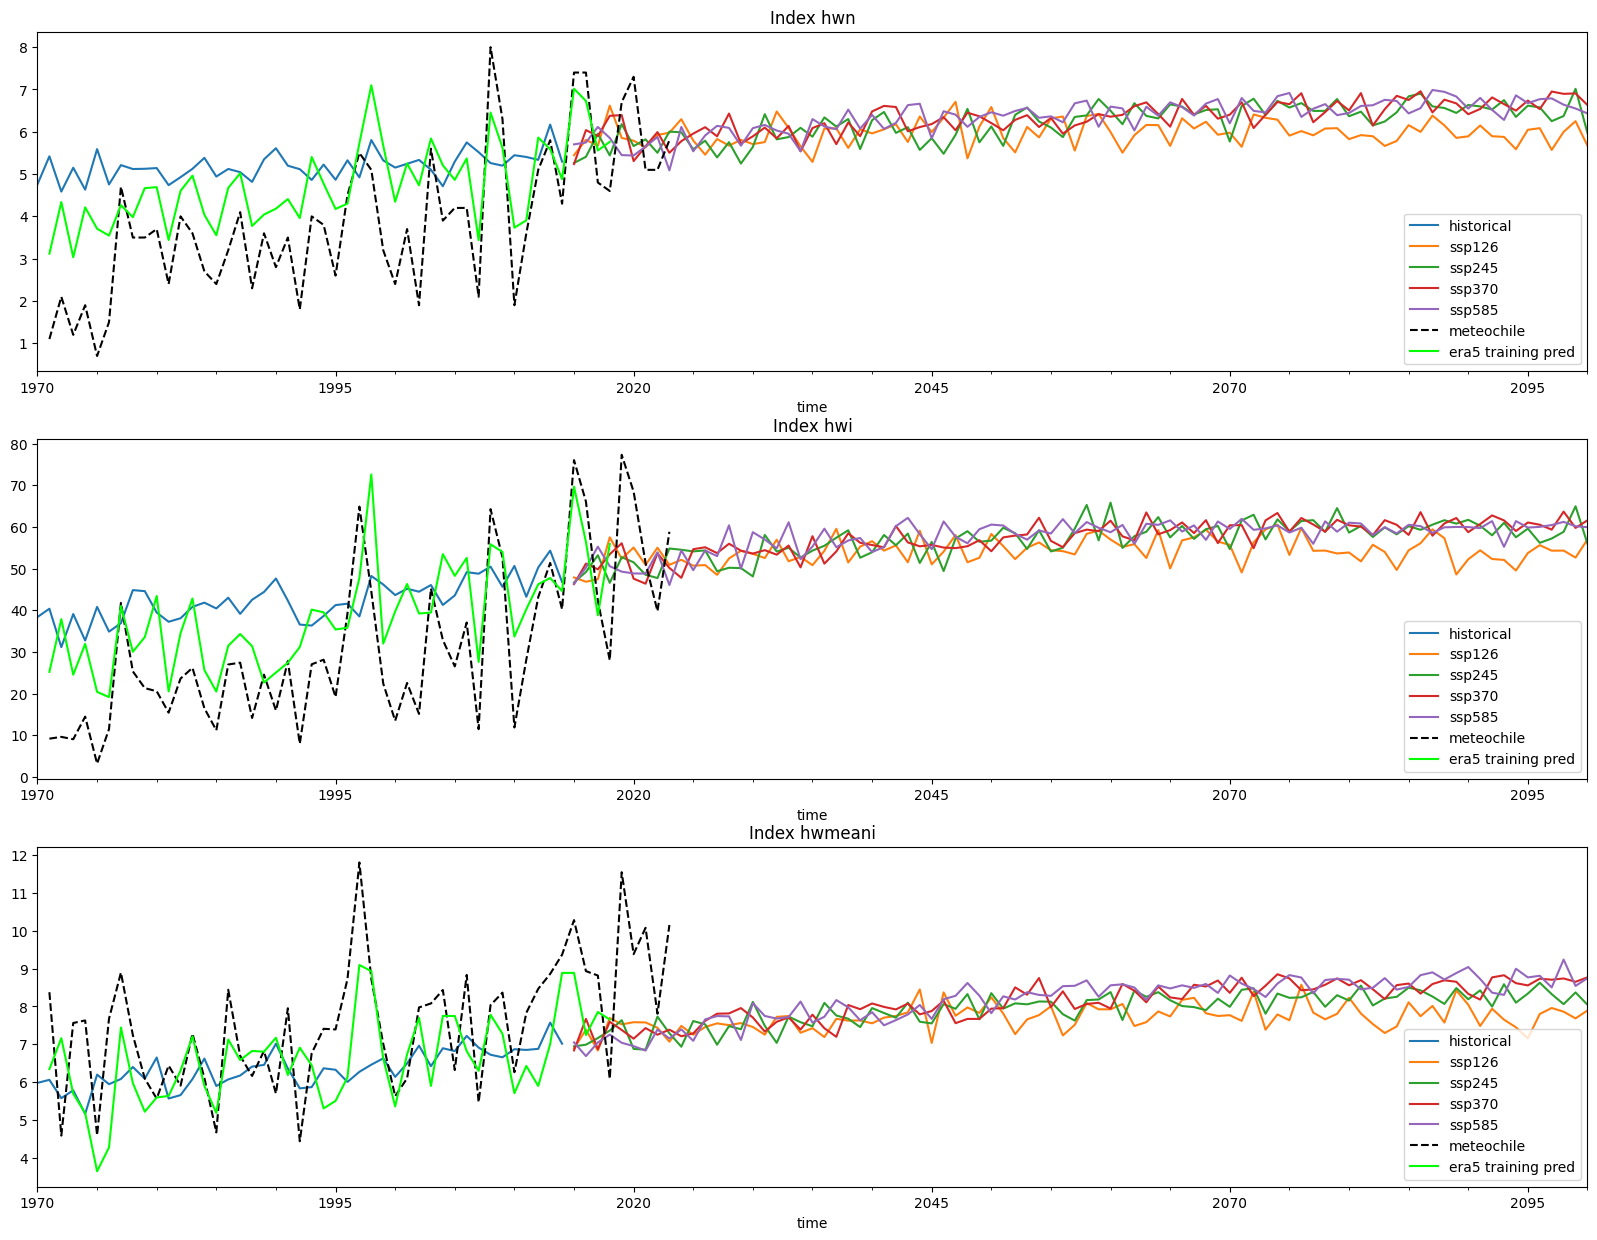

In [35]:
model = "mean"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 15))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")

### Mean Predictions vs Mean Detection

In [36]:
hw_mean_scenario = {}
models = list(hws_chile_model_scenario_yearly.keys())
for scenario in scenarios:
    
    all_models = pd.concat([hws_chile_model_scenario_yearly[model][scenario] for model in models], axis=1)
    df_mean_scenario = pd.DataFrame(columns=indices, index=hws_chile_model_scenario_yearly["EC-Earth3"][scenario].index)
    for index in indices:
        df_mean_scenario[index] = all_models[index].mean(axis=1)

    hw_mean_scenario[scenario] = df_mean_scenario

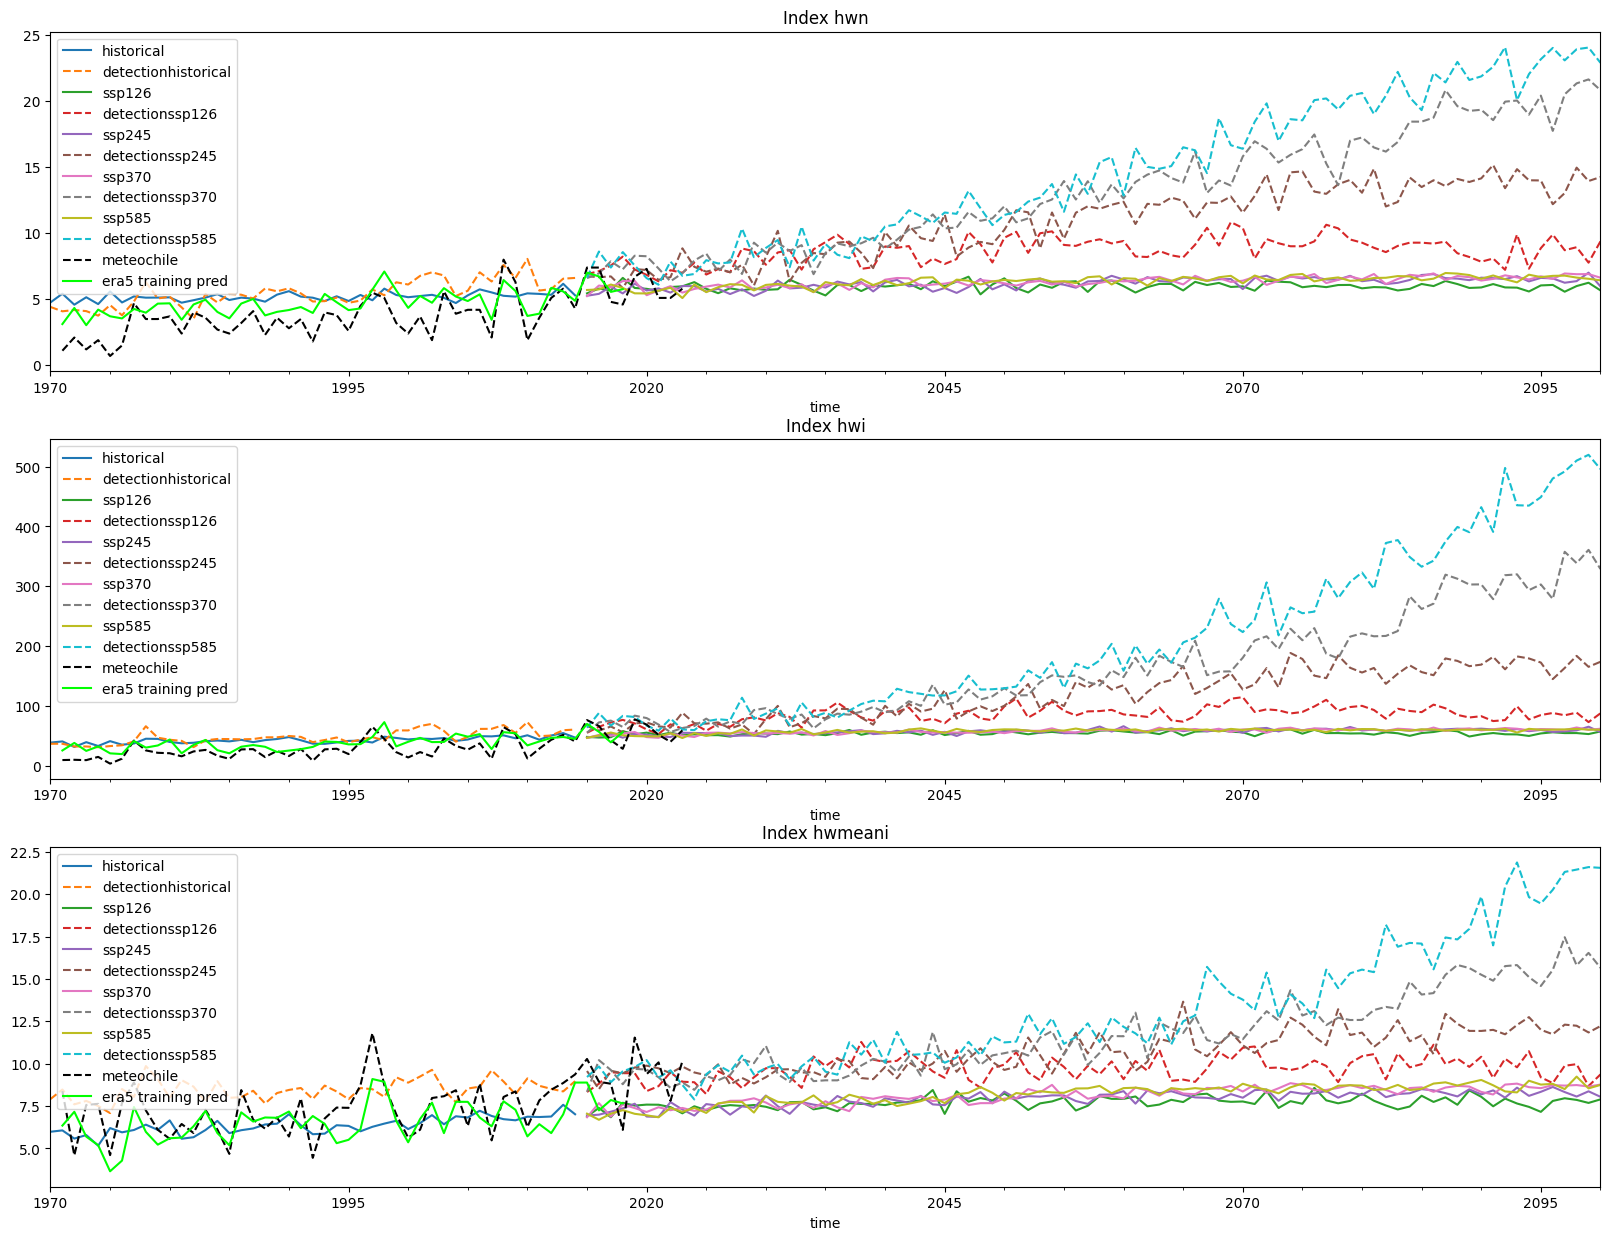

In [37]:
model = "mean"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 15))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
        values = hw_mean_scenario[scenario][index].values
        new_df = pd.DataFrame(values, columns=[index], index=df.index)
        # axs[i].plot(df.index, values, label=f"detection {scenario}")
        new_df.plot(y=index, ax=axs[i], label=f"detection{scenario}", linestyle="--")
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")
    axs[i].legend()

### Mathematical Validation

In [38]:
def compare_relationships(models_dict):
    """
    Compare mathematical relationships between heatwave indices for each model.

    Parameters
    ----------
    models_dict : dict
        Dictionary of {model_name: dataframe} containing indices.

    Returns
    -------
    dict
        Dictionary {model_name: dataframe} with comparison results.
    """
    tol = 1e-6

    results = {model : {} for model in models_dict.keys()}

    for model, dict in models_dict.items():
        for scenario, df in dict.items():
            comp_df = pd.DataFrame(index=df.index)

            # Expected values
            # exp_hwi = df["hwm"] * df["hwf"]
            # exp_hwmeand   = df["hwf"] / df["hwn"]
            exp_hwmeani   = df["hwi"] / df["hwn"]

            # Relative differences
            # comp_df["rel_diff_hwi"] = (df["hwi"] - exp_hwi) / (exp_hwi + tol)
            # comp_df["rel_diff_hwmeand"]   = (df["hwmeand"]   - exp_hwmeand)   / (exp_hwmeand   + tol)
            comp_df["rel_diff_hwmeani"]   = (df["hwmeani"]   - exp_hwmeani)   / (exp_hwmeani   + tol)

            # Inequalities → booleans
            # comp_df["hwd_ge_hwmd"] = df["hwd"] >= df["hwmeand"]
            # comp_df["hwa_ge_hwm"]  = df["hwa"] >= df["hwm"]
            # comp_df["hwmaxi_ge_hwmeani"]  = df["hwmaxi"] >= df["hwmeani"]
            # comp_df["hwmi_ge_hwmeani"]  = df["hwi"] >= df["hwmeani"]
            results[model][scenario] = comp_df

    return results


In [39]:
yearly_checks = compare_relationships(models_predicted_yearly)

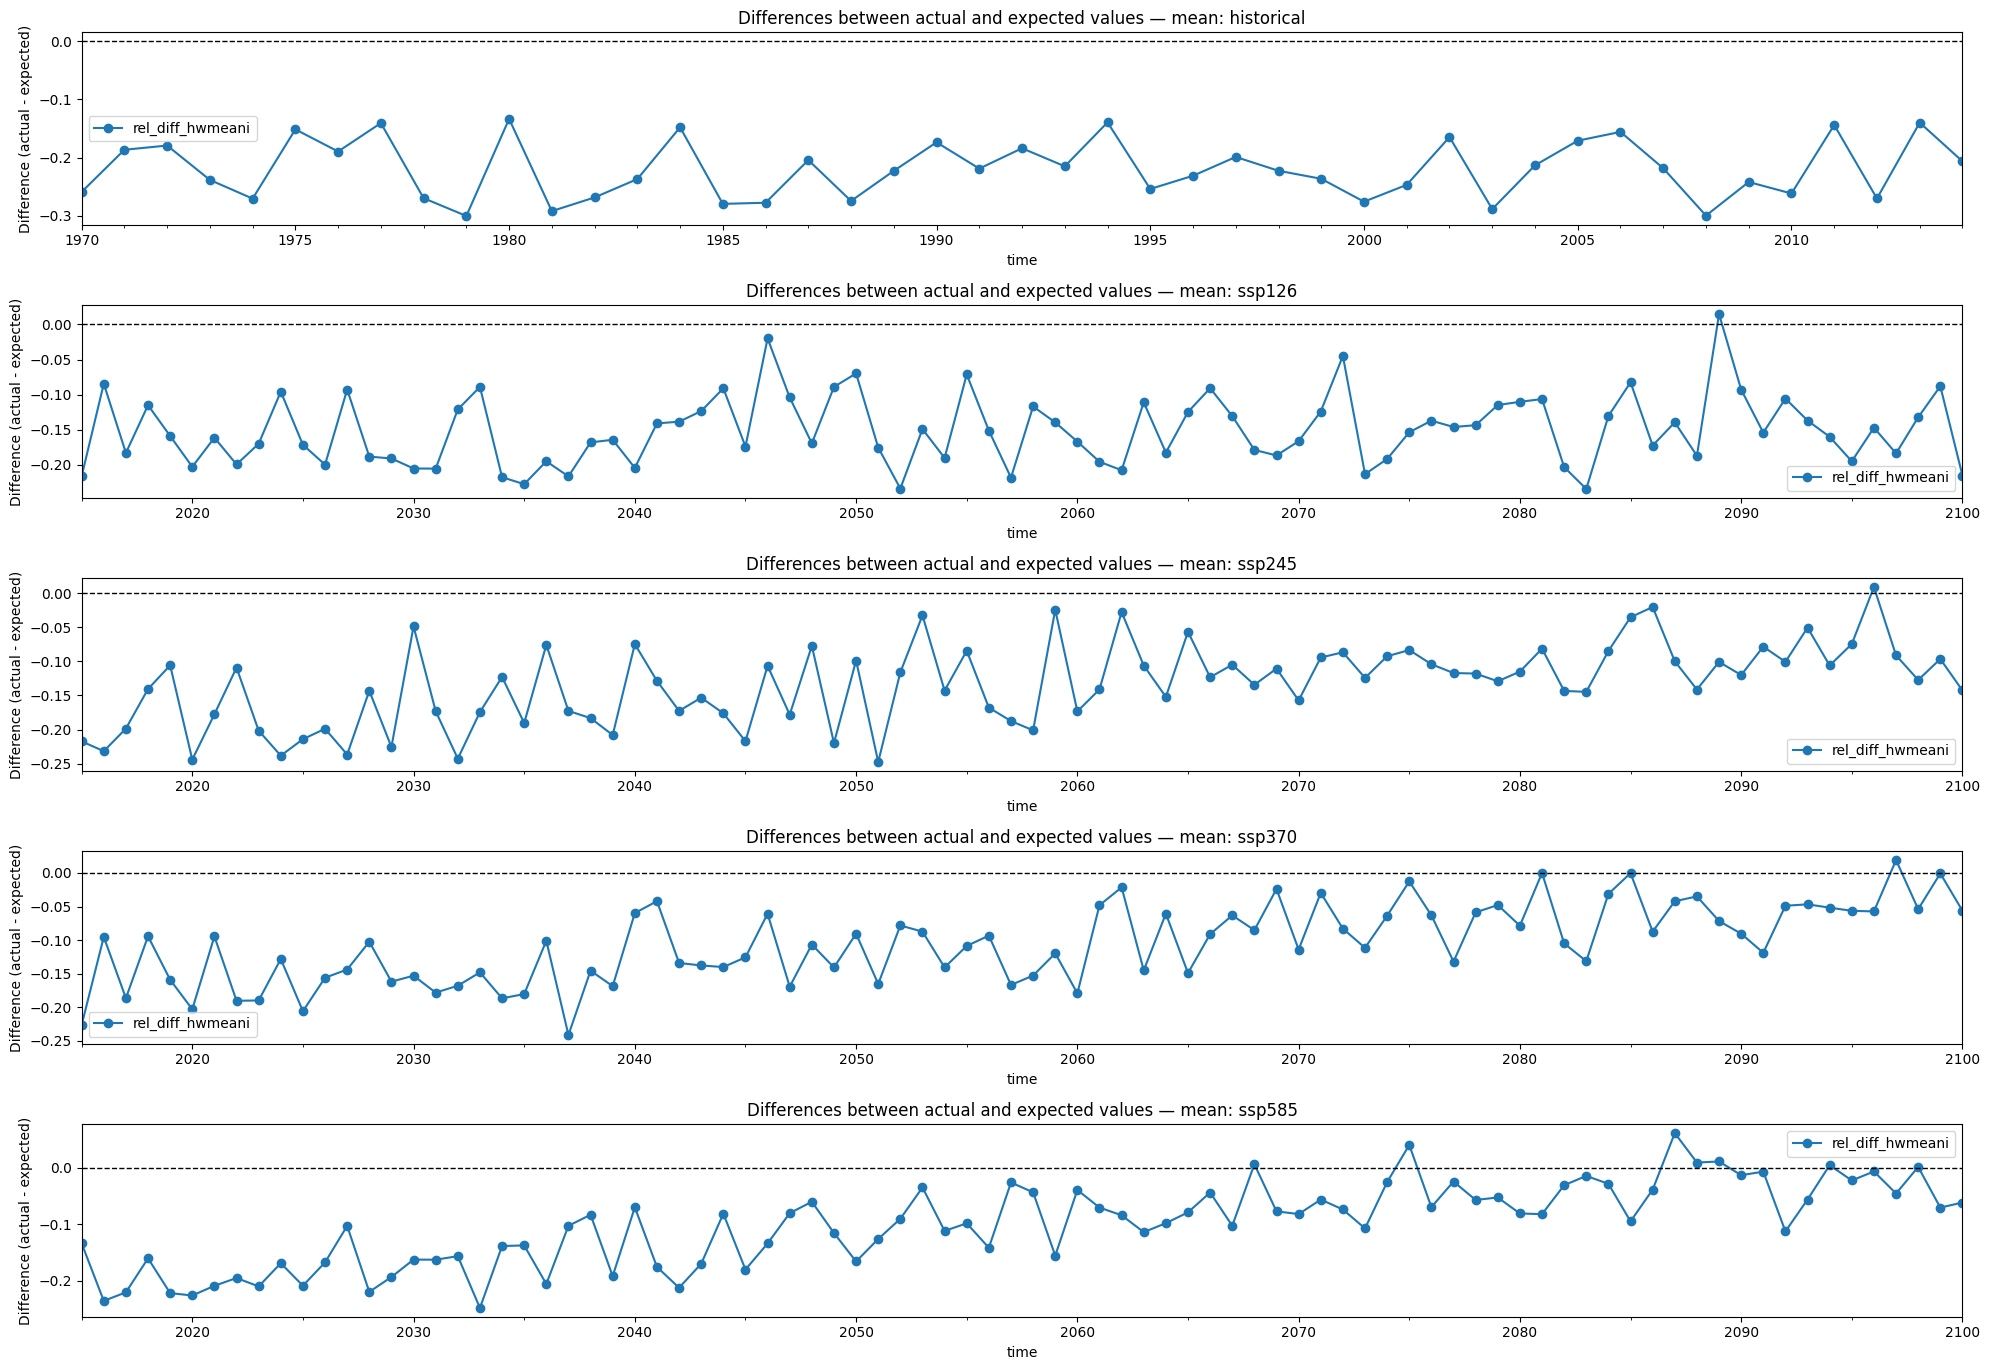

In [40]:
def plot_differences(model_name, checks_dict):

    fig, ax = plt.subplots(len(scenarios), figsize=(20, 15))
    for i,scenario in enumerate(scenarios):
        df = checks_dict[model_name][scenario]
        df[["rel_diff_hwmeani"]].plot(ax=ax[i], marker="o")
        ax[i].axhline(0, color="black", linestyle="--", linewidth=1)
        ax[i].set_title(f"Differences between actual and expected values — {model_name}: {scenario}")
        ax[i].set_ylabel("Difference (actual - expected)")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
    plt.show()

# Example: yearly
plot_differences("mean", yearly_checks)


## Maximum Labels: hwd, hwa, hwmaxi

In [41]:
indices_of_interest = ["hwd", "hwa", "hwmaxi"]
hws_labels = hws_chile[indices_of_interest]
era5_df = pd.concat((historical_dfs["ERA5"],hws_labels),axis=1)

In [42]:
meteochile_yearly = transform_time_label(era5_df[indices_of_interest], "year")

In [43]:
bounds = (-1.1692892810242344, -0.30647585455315646, 3.0, 6.499969486244418)
loss_fn=SERA(bounds=bounds,T=100, initial_weight=0.1, fn="piecewise2")
models_scenario_predicted = {model: {} for model in cmip6_drivers_dfs.keys()}
seasons_label_scalers = {}
df_pred_train = pd.DataFrame(columns=indices_of_interest, index=era5_df.index)

for i in range(1,13):
    df_season = era5_df[era5_df.index.month==i]
    cnn_rnn_model = Sequential([
            Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(era5_df.columns) - len(indices_of_interest))),
            Reshape((1, 16)),  # Back to time dimension
            SimpleRNN(8, activation="tanh"),
            Dropout(0.1),
            Dense(len(indices_of_interest))
        ])
    pred = PredictionModel(df_season, i, indices_of_interest, cnn_rnn_model, name_regressor="CNNRNN16",loss_fn=loss_fn)
    seasons_label_scalers[i] = pred.label_scaler
    pred.compile_keras_model()
    
    y_train, y_pred_train = pred.train(5)
    df_pred_train.loc[df_season.index[:-5]] = pred.label_scaler.inverse_transform(y_pred_train)
    df_pred_train.sort_index(inplace=True)
    for name, scenarios_df in cmip6_drivers_dfs.items():
        for scenario in scenarios:
            if i==1:
                models_scenario_predicted[name][scenario] = pd.DataFrame()
            df_target = scenarios_df[scenario][scenarios_df[scenario].index.month==i]
            if scenario == "historical":
                df_target = df_target[(df_target.index.year >=1970) & (df_target.index.year <= 2014)]
            else:
                df_target = df_target[(df_target.index.year >=2015) & (df_target.index.year <= 2100)]
            # df_target[indices_of_interest] = df_season[indices_of_interest]
            # Normalize cmip6 features for machine input
            target = pred.scaler_X.transform(df_target[pred.scaler_X.feature_names_in_])
            # Reshape for keras and predict
            predicted_normalized = pred.regressor.predict(pred.reshape_for_keras(target))
            # Transform back to original range
            predicted_real = pred.label_scaler.inverse_transform(predicted_normalized)
            predicted = pd.DataFrame(predicted_real).rename(columns={i: label for i,label in enumerate(indices_of_interest)})
            predicted["Date"] = df_target.index
            predicted.set_index("Date",inplace=True)
            models_scenario_predicted[name][scenario] = pd.concat((models_scenario_predicted[name][scenario],predicted),axis=0)
        
df_pred_train = df_pred_train.dropna()
df_pred_train = df_pred_train.astype(np.number)


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 3ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 3ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 753us/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 1ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 3ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 3ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 5ms/step


c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\common.py:1687: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)


### Build Mean Prediction of all models

In [44]:
mean_scenario = {}
for scenario in scenarios:
    temp_df = pd.DataFrame()
    for name, model_scenario in models_scenario_predicted.items():
        temp_df = pd.concat((temp_df, model_scenario[scenario]), axis=1)
        
    mean_scenario[scenario] = pd.DataFrame(columns=models_scenario_predicted["EC-Earth3"][scenario].columns,index=model_scenario[scenario].index)
    for col in np.unique(temp_df.columns):
        mean_scenario[scenario][col] = temp_df[col].mean(axis=1)
models_scenario_predicted["mean"] = mean_scenario

for scenario in scenarios:
    models_scenario_predicted["mean"][scenario] = models_scenario_predicted["mean"][scenario].astype(np.float64)
models_predicted_yearly = {model: {} for model in models_scenario_predicted.keys()}
models_predicted_decadal = {model: {} for model in models_scenario_predicted.keys()}

for name, model_scenario in models_scenario_predicted.items():
    for scenario, df in model_scenario.items():
        
        models_predicted_yearly[name][scenario] = transform_time_label(df, "year")
        models_predicted_decadal[name][scenario] = transform_time_label(df, "decade")

pred_train_yearly = transform_time_label(df_pred_train, "year")

### Mean of predicted Models

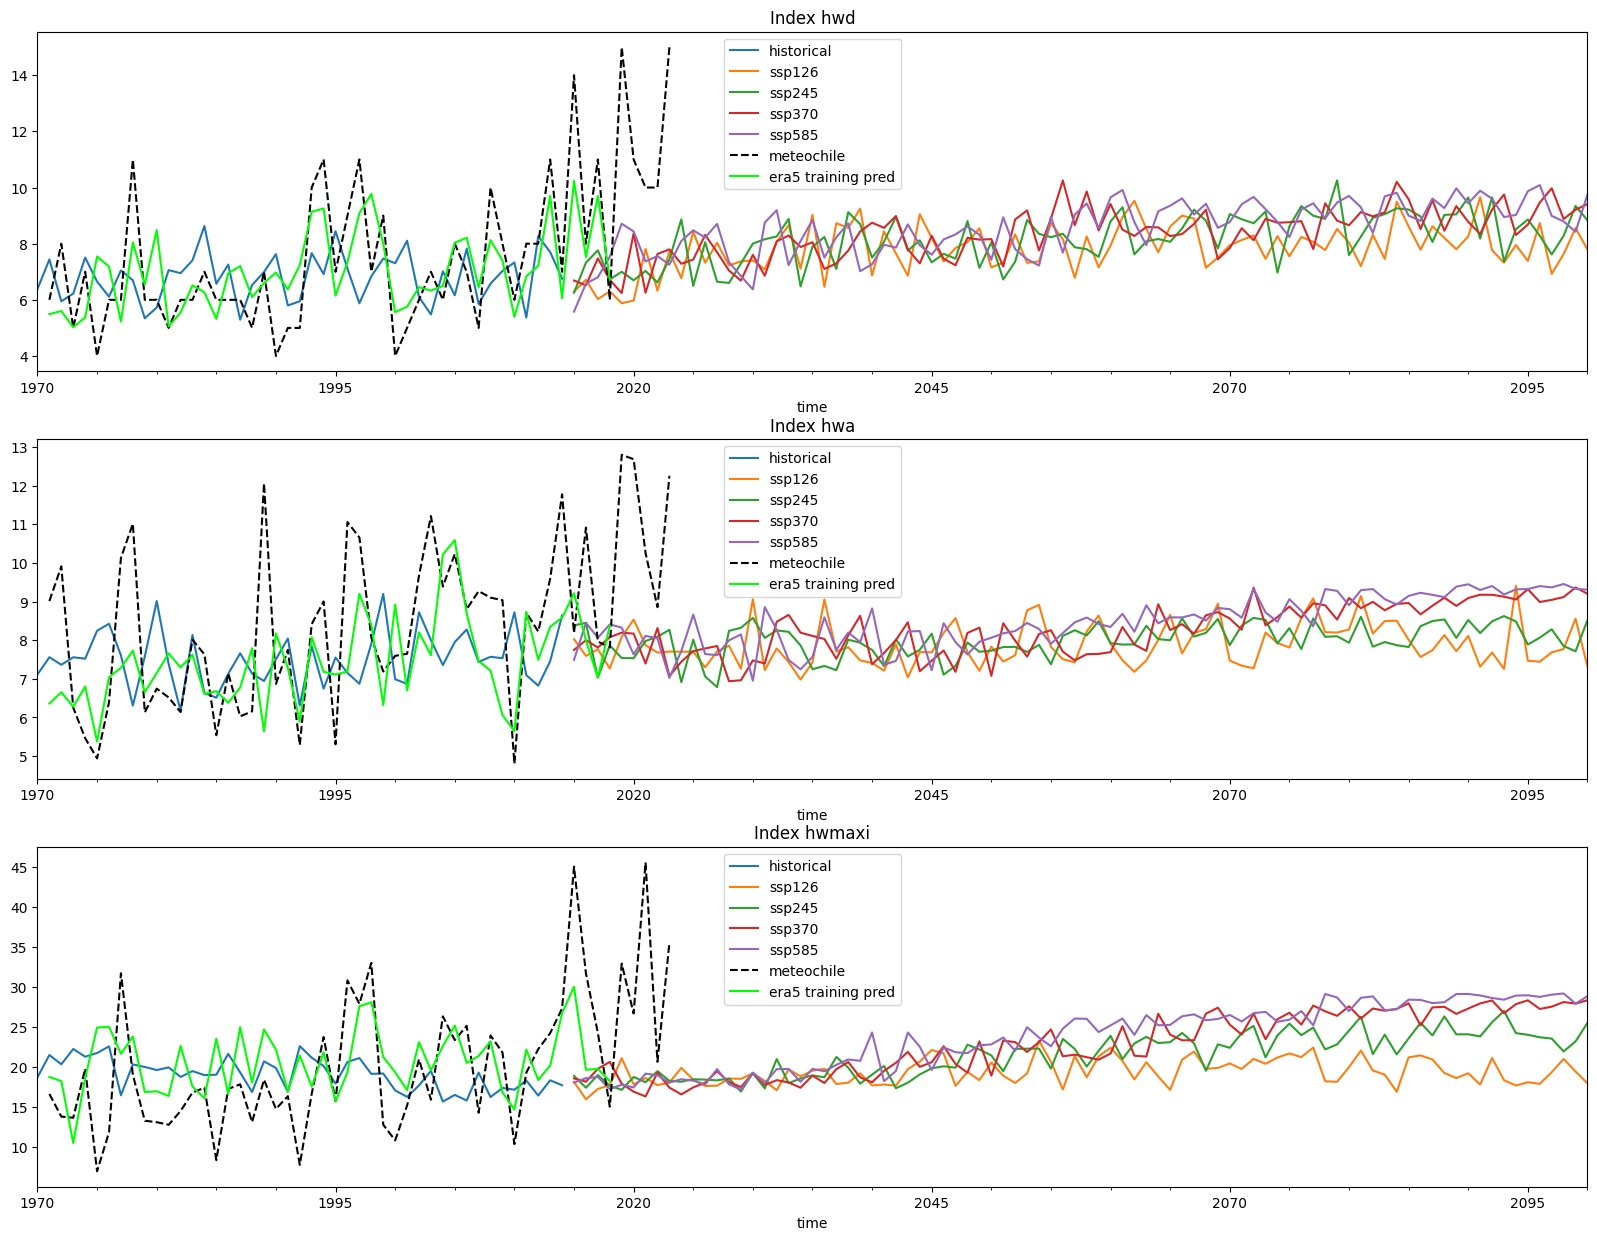

In [45]:
model = "mean"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 15))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")

### Mean Predictions vs Mean Detection

In [46]:
hw_mean_scenario = {}
models = list(hws_chile_model_scenario_yearly.keys())
for scenario in scenarios:
    
    all_models = pd.concat([hws_chile_model_scenario_yearly[model][scenario] for model in models], axis=1)
    df_mean_scenario = pd.DataFrame(columns=indices, index=hws_chile_model_scenario_yearly["EC-Earth3"][scenario].index)
    for index in indices:
        df_mean_scenario[index] = all_models[index].mean(axis=1)

    hw_mean_scenario[scenario] = df_mean_scenario

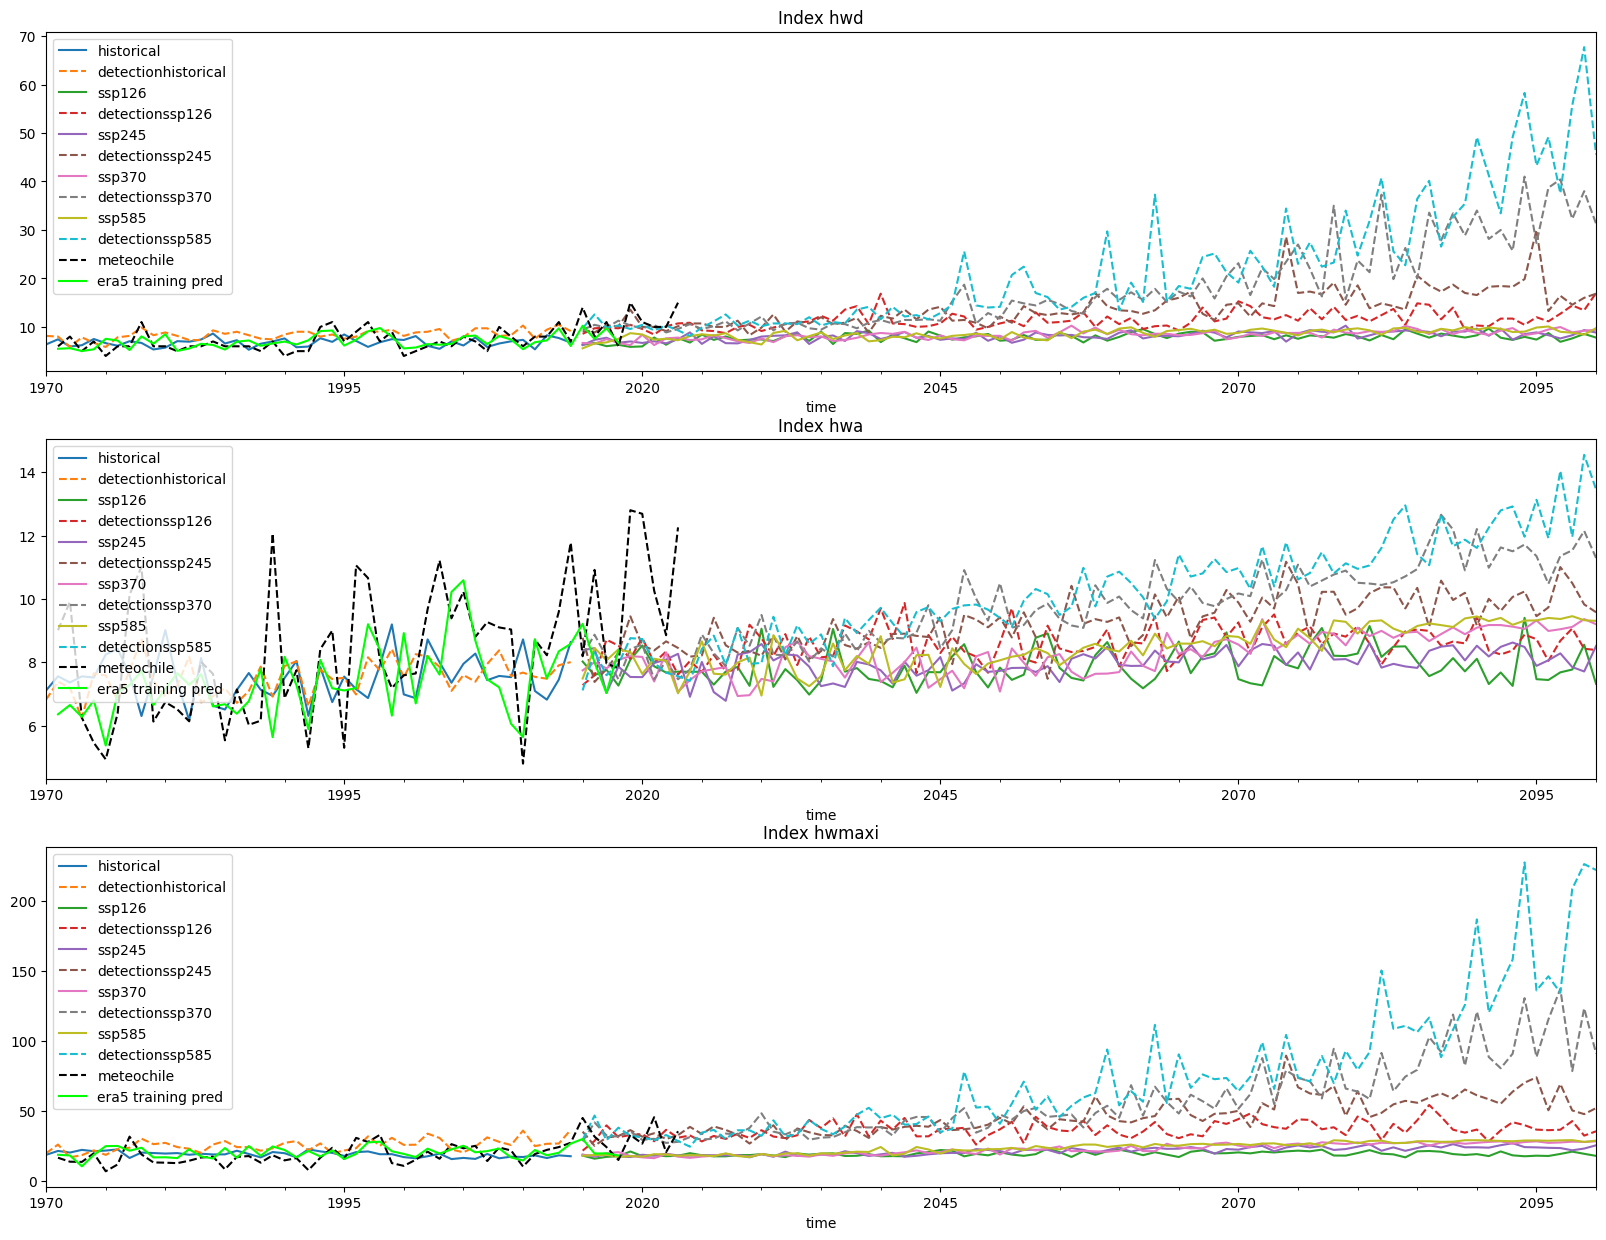

In [47]:
model = "mean"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 15))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
        values = hw_mean_scenario[scenario][index].values
        new_df = pd.DataFrame(values, columns=[index], index=df.index)
        # axs[i].plot(df.index, values, label=f"detection {scenario}")
        new_df.plot(y=index, ax=axs[i], label=f"detection{scenario}", linestyle="--")
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")
    axs[i].legend()

## Frequency labels: hwn, hwf, hwd, hwmeand

In [48]:
indices_of_interest = ["hwn", "hwf", "hwd", "hwmeand"]
hws_labels = hws_chile[indices_of_interest]
era5_df = pd.concat((historical_dfs["ERA5"],hws_labels),axis=1)

In [49]:
meteochile_yearly = transform_time_label(era5_df[indices_of_interest], "year")

In [ ]:
bounds = (-1.1692892810242344, -0.30647585455315646, 3.0, 6.499969486244418)
loss_fn=SERA(bounds=bounds,T=100, initial_weight=0.1, fn="piecewise2")
models_scenario_predicted = {model: {} for model in cmip6_drivers_dfs.keys()}
seasons_label_scalers = {}
df_pred_train = pd.DataFrame(columns=indices_of_interest, index=era5_df.index)

for i in range(1,13):
    df_season = era5_df[era5_df.index.month==i]
    cnn_rnn_model = Sequential([
            Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(era5_df.columns) - len(indices_of_interest))),
            Reshape((1, 16)),  # Back to time dimension
            SimpleRNN(8, activation="tanh"),
            Dropout(0.1),
            Dense(len(indices_of_interest))
        ])
    pred = PredictionModel(df_season, i, indices_of_interest, cnn_rnn_model, name_regressor="CNNRNN16",loss_fn=loss_fn)
    seasons_label_scalers[i] = pred.label_scaler
    pred.compile_keras_model()
    
    y_train, y_pred_train = pred.train(5)
    df_pred_train.loc[df_season.index[:-5]] = pred.label_scaler.inverse_transform(y_pred_train)
    df_pred_train.sort_index(inplace=True)
    for name, scenarios_df in cmip6_drivers_dfs.items():
        for scenario in scenarios:
            if i==1:
                models_scenario_predicted[name][scenario] = pd.DataFrame()
            df_target = scenarios_df[scenario][scenarios_df[scenario].index.month==i]
            if scenario == "historical":
                df_target = df_target[(df_target.index.year >=1970) & (df_target.index.year <= 2014)]
            else:
                df_target = df_target[(df_target.index.year >=2015) & (df_target.index.year <= 2100)]
            # df_target[indices_of_interest] = df_season[indices_of_interest]
            # Normalize cmip6 features for machine input
            target = pred.scaler_X.transform(df_target[pred.scaler_X.feature_names_in_])
            # Reshape for keras and predict
            predicted_normalized = pred.regressor.predict(pred.reshape_for_keras(target))
            # Transform back to original range
            predicted_real = pred.label_scaler.inverse_transform(predicted_normalized)
            predicted = pd.DataFrame(predicted_real).rename(columns={i: label for i,label in enumerate(indices_of_interest)})
            predicted["Date"] = df_target.index
            predicted.set_index("Date",inplace=True)
            models_scenario_predicted[name][scenario] = pd.concat((models_scenario_predicted[name][scenario],predicted),axis=0)
        
df_pred_train = df_pred_train.dropna()
df_pred_train = df_pred_train.astype(np.number)


### Build Mean Prediction of all models

In [51]:
mean_scenario = {}
for scenario in scenarios:
    temp_df = pd.DataFrame()
    for name, model_scenario in models_scenario_predicted.items():
        temp_df = pd.concat((temp_df, model_scenario[scenario]), axis=1)
        
    mean_scenario[scenario] = pd.DataFrame(columns=models_scenario_predicted["EC-Earth3"][scenario].columns,index=model_scenario[scenario].index)
    for col in np.unique(temp_df.columns):
        mean_scenario[scenario][col] = temp_df[col].mean(axis=1)
models_scenario_predicted["mean"] = mean_scenario

for scenario in scenarios:
    models_scenario_predicted["mean"][scenario] = models_scenario_predicted["mean"][scenario].astype(np.float64)
models_predicted_yearly = {model: {} for model in models_scenario_predicted.keys()}
models_predicted_decadal = {model: {} for model in models_scenario_predicted.keys()}

for name, model_scenario in models_scenario_predicted.items():
    for scenario, df in model_scenario.items():
        
        models_predicted_yearly[name][scenario] = transform_time_label(df, "year")
        models_predicted_decadal[name][scenario] = transform_time_label(df, "decade")

pred_train_yearly = transform_time_label(df_pred_train, "year")

### Mean of predicted Models

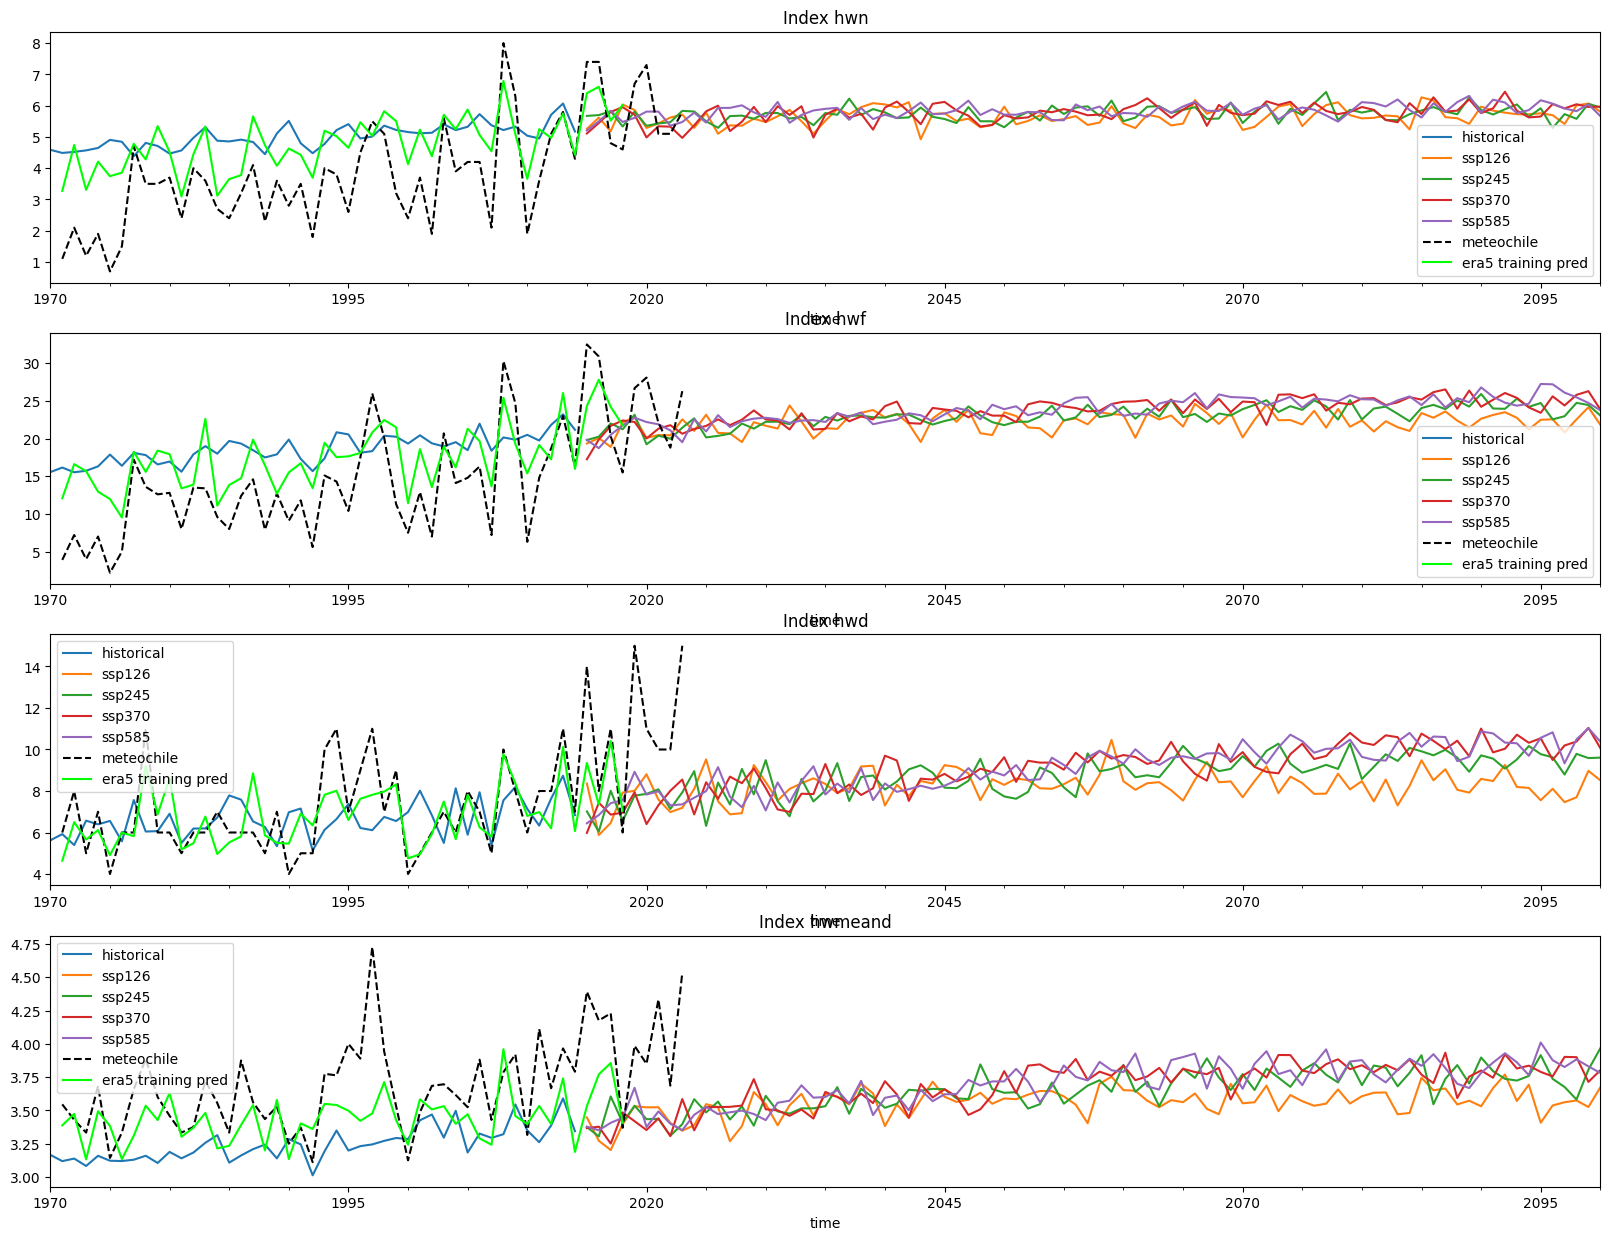

In [52]:
model = "mean"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 15))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")

### Mean Predictions vs Mean Detection

In [53]:
hw_mean_scenario = {}
models = list(hws_chile_model_scenario_yearly.keys())
for scenario in scenarios:
    
    all_models = pd.concat([hws_chile_model_scenario_yearly[model][scenario] for model in models], axis=1)
    df_mean_scenario = pd.DataFrame(columns=indices, index=hws_chile_model_scenario_yearly["EC-Earth3"][scenario].index)
    for index in indices:
        df_mean_scenario[index] = all_models[index].mean(axis=1)

    hw_mean_scenario[scenario] = df_mean_scenario

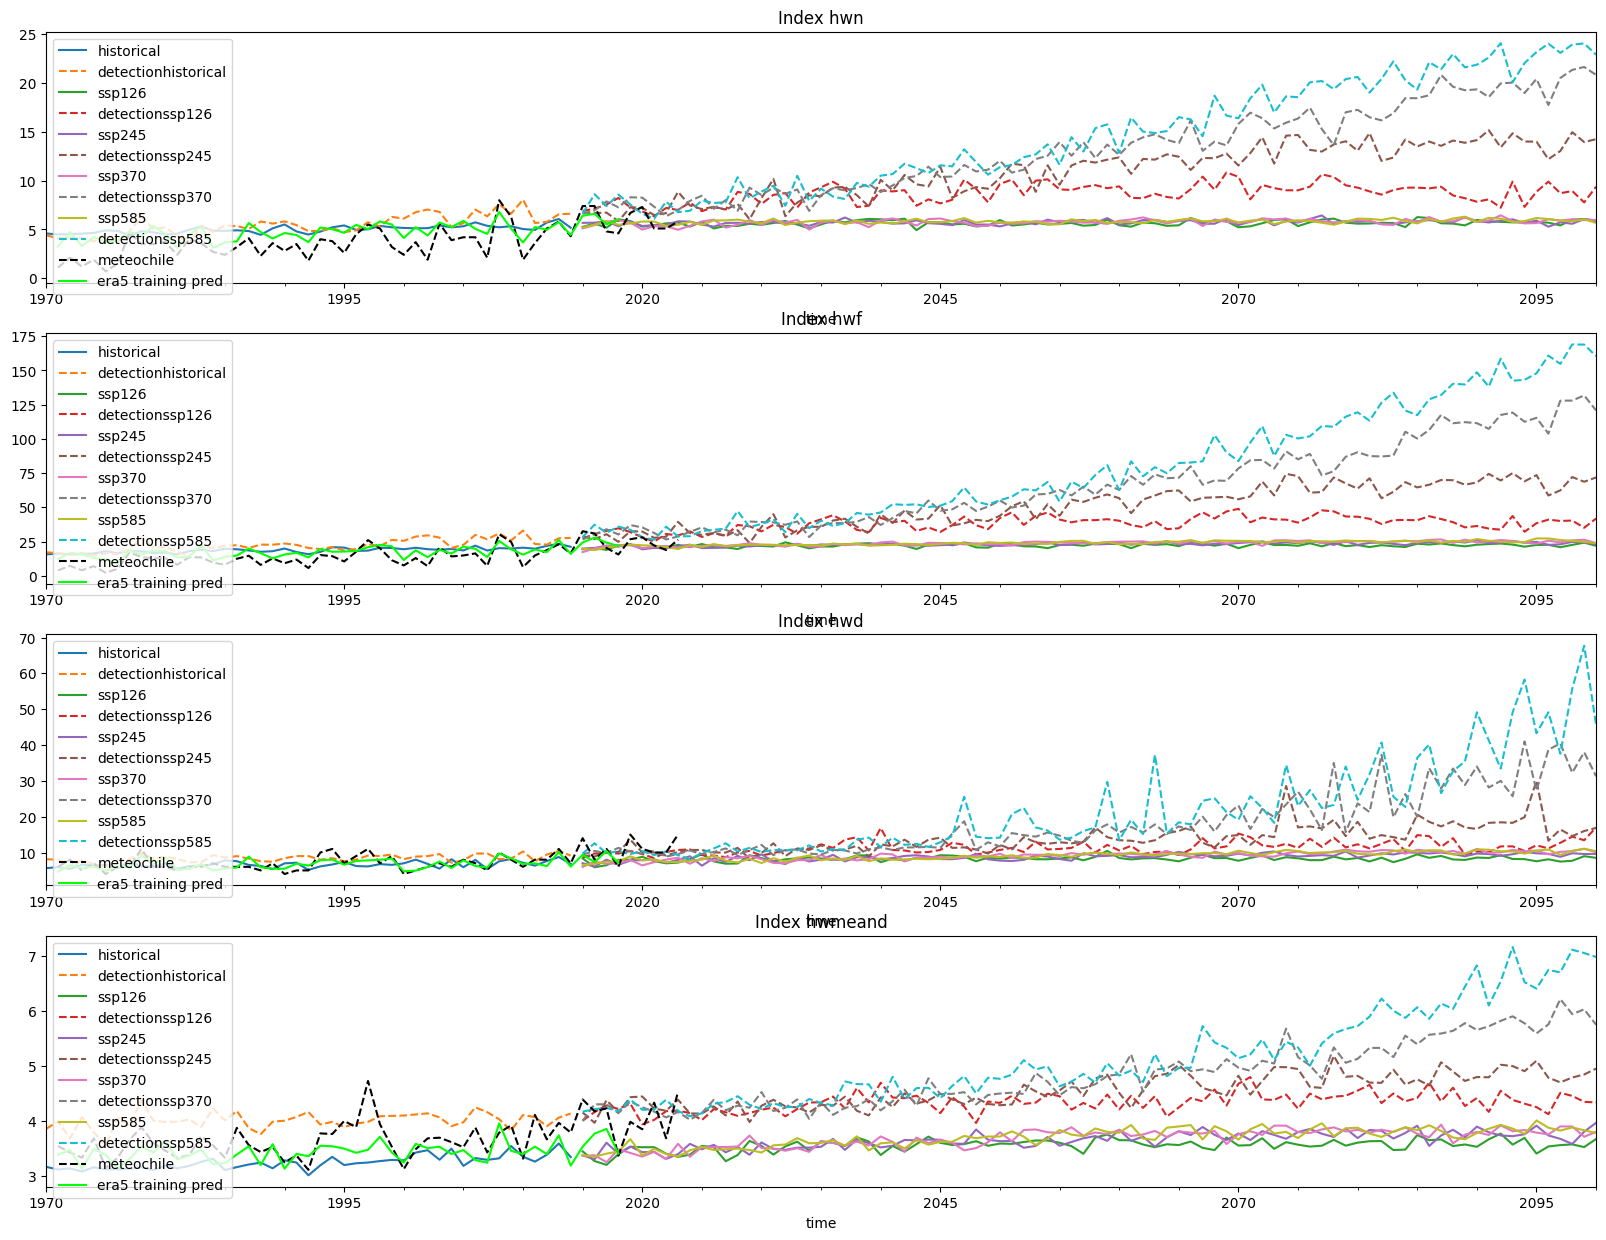

In [54]:
model = "mean"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 15))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
        values = hw_mean_scenario[scenario][index].values
        new_df = pd.DataFrame(values, columns=[index], index=df.index)
        # axs[i].plot(df.index, values, label=f"detection {scenario}")
        new_df.plot(y=index, ax=axs[i], label=f"detection{scenario}", linestyle="--")
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")
    axs[i].legend()

### Mathematical Validation

In [55]:
def compare_relationships(models_dict):
    """
    Compare mathematical relationships between heatwave indices for each model.

    Parameters
    ----------
    models_dict : dict
        Dictionary of {model_name: dataframe} containing indices.

    Returns
    -------
    dict
        Dictionary {model_name: dataframe} with comparison results.
    """
    tol = 1e-6

    results = {model : {} for model in models_dict.keys()}

    for model, dict in models_dict.items():
        for scenario, df in dict.items():
            comp_df = pd.DataFrame(index=df.index)

            # Expected values
            # exp_hwi = df["hwm"] * df["hwf"]
            exp_hwmeand   = df["hwf"] / df["hwn"]
            # exp_hwmeani   = df["hwi"] / df["hwn"]

            # Relative differences
            # comp_df["rel_diff_hwi"] = (df["hwi"] - exp_hwi) / (exp_hwi + tol)
            comp_df["rel_diff_hwmeand"]   = (df["hwmeand"]   - exp_hwmeand)   / (exp_hwmeand   + tol)
            # comp_df["rel_diff_hwmeani"]   = (df["hwmeani"]   - exp_hwmeani)   / (exp_hwmeani   + tol)

            # Inequalities → booleans
            # comp_df["hwd_ge_hwmd"] = df["hwd"] >= df["hwmeand"]
            # comp_df["hwa_ge_hwm"]  = df["hwa"] >= df["hwm"]
            # comp_df["hwmaxi_ge_hwmeani"]  = df["hwmaxi"] >= df["hwmeani"]
            # comp_df["hwmi_ge_hwmeani"]  = df["hwi"] >= df["hwmeani"]
            results[model][scenario] = comp_df

    return results


In [56]:
yearly_checks = compare_relationships(models_predicted_yearly)

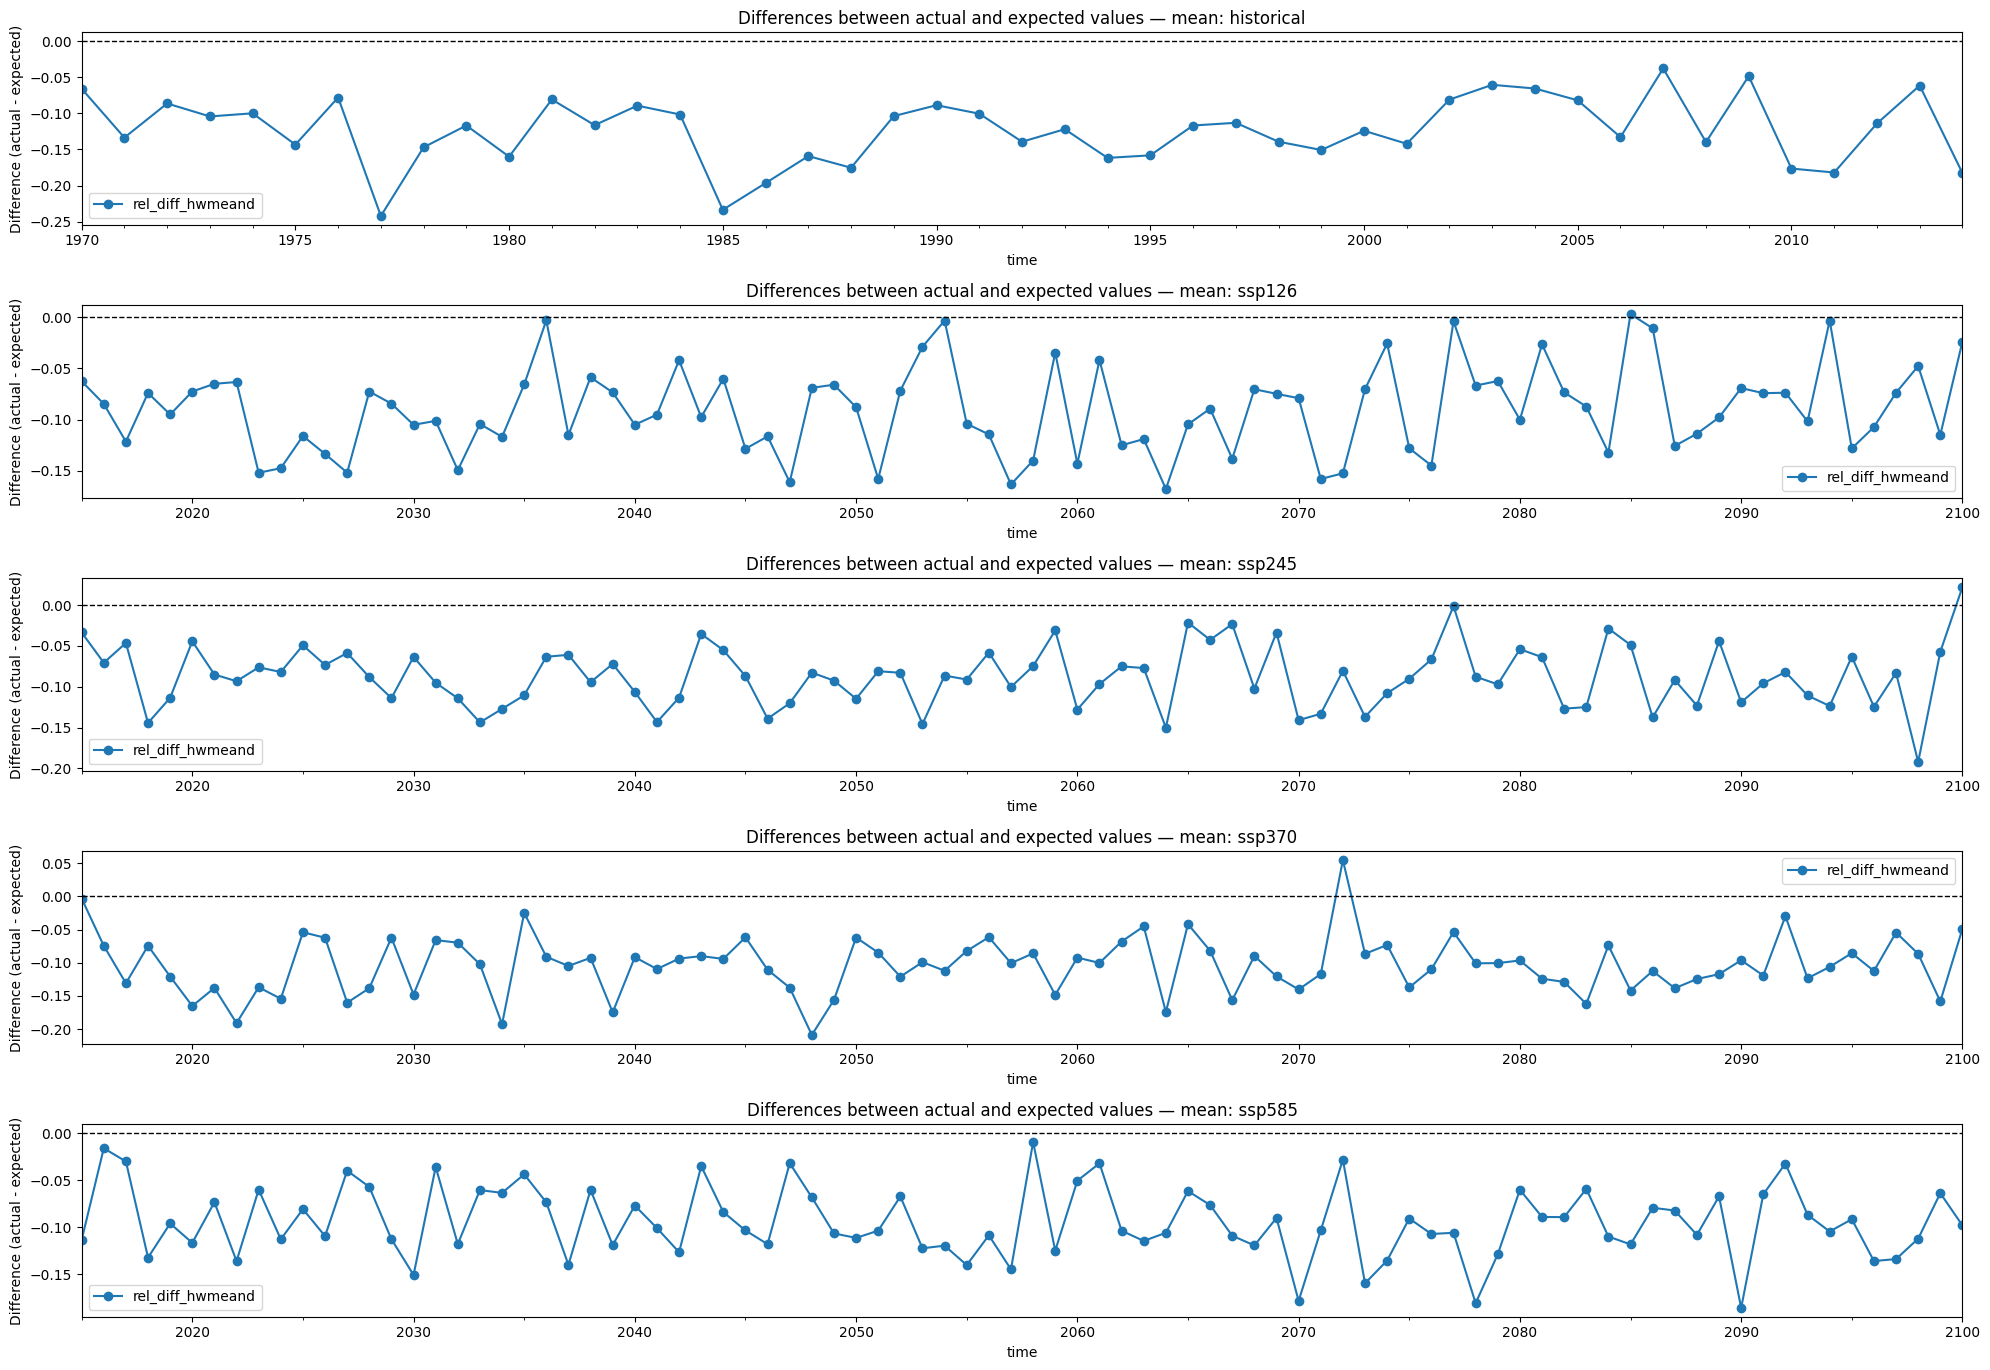

In [57]:
def plot_differences(model_name, checks_dict):

    fig, ax = plt.subplots(len(scenarios), figsize=(20, 15))
    for i,scenario in enumerate(scenarios):
        df = checks_dict[model_name][scenario]
        df[["rel_diff_hwmeand"]].plot(ax=ax[i], marker="o")
        ax[i].axhline(0, color="black", linestyle="--", linewidth=1)
        ax[i].set_title(f"Differences between actual and expected values — {model_name}: {scenario}")
        ax[i].set_ylabel("Difference (actual - expected)")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
    plt.show()

# Example: yearly
plot_differences("mean", yearly_checks)


## Intensity labels: hwa, hwi, hwmeani, hwmaxi

In [58]:
indices_of_interest = ["hwn", "hwa", "hwi", "hwmeani", "hwmaxi"]
hws_labels = hws_chile[indices_of_interest]
era5_df = pd.concat((historical_dfs["ERA5"],hws_labels),axis=1)

In [59]:
meteochile_yearly = transform_time_label(era5_df[indices_of_interest], "year")

In [ ]:
bounds = (-1.1692892810242344, -0.30647585455315646, 3.0, 6.499969486244418)
loss_fn=SERA(bounds=bounds,T=100, initial_weight=0.1, fn="piecewise2")
models_scenario_predicted = {model: {} for model in cmip6_drivers_dfs.keys()}
seasons_label_scalers = {}
df_pred_train = pd.DataFrame(columns=indices_of_interest, index=era5_df.index)

for i in range(1,13):
    df_season = era5_df[era5_df.index.month==i]
    cnn_rnn_model = Sequential([
            Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(era5_df.columns) - len(indices_of_interest))),
            Reshape((1, 16)),  # Back to time dimension
            SimpleRNN(8, activation="tanh"),
            Dropout(0.1),
            Dense(len(indices_of_interest))
        ])
    pred = PredictionModel(df_season, i, indices_of_interest, cnn_rnn_model, name_regressor="CNNRNN16",loss_fn=loss_fn)
    seasons_label_scalers[i] = pred.label_scaler
    pred.compile_keras_model()
    
    y_train, y_pred_train = pred.train(5)
    df_pred_train.loc[df_season.index[:-5]] = pred.label_scaler.inverse_transform(y_pred_train)
    df_pred_train.sort_index(inplace=True)
    for name, scenarios_df in cmip6_drivers_dfs.items():
        for scenario in scenarios:
            if i==1:
                models_scenario_predicted[name][scenario] = pd.DataFrame()
            df_target = scenarios_df[scenario][scenarios_df[scenario].index.month==i]
            if scenario == "historical":
                df_target = df_target[(df_target.index.year >=1970) & (df_target.index.year <= 2014)]
            else:
                df_target = df_target[(df_target.index.year >=2015) & (df_target.index.year <= 2100)]
            # df_target[indices_of_interest] = df_season[indices_of_interest]
            # Normalize cmip6 features for machine input
            target = pred.scaler_X.transform(df_target[pred.scaler_X.feature_names_in_])
            # Reshape for keras and predict
            predicted_normalized = pred.regressor.predict(pred.reshape_for_keras(target))
            # Transform back to original range
            predicted_real = pred.label_scaler.inverse_transform(predicted_normalized)
            predicted = pd.DataFrame(predicted_real).rename(columns={i: label for i,label in enumerate(indices_of_interest)})
            predicted["Date"] = df_target.index
            predicted.set_index("Date",inplace=True)
            models_scenario_predicted[name][scenario] = pd.concat((models_scenario_predicted[name][scenario],predicted),axis=0)
        
df_pred_train = df_pred_train.dropna()
df_pred_train = df_pred_train.astype(np.number)


### Build Mean Prediction of all models

In [61]:
mean_scenario = {}
for scenario in scenarios:
    temp_df = pd.DataFrame()
    for name, model_scenario in models_scenario_predicted.items():
        temp_df = pd.concat((temp_df, model_scenario[scenario]), axis=1)
        
    mean_scenario[scenario] = pd.DataFrame(columns=models_scenario_predicted["EC-Earth3"][scenario].columns,index=model_scenario[scenario].index)
    for col in np.unique(temp_df.columns):
        mean_scenario[scenario][col] = temp_df[col].mean(axis=1)
models_scenario_predicted["mean"] = mean_scenario

for scenario in scenarios:
    models_scenario_predicted["mean"][scenario] = models_scenario_predicted["mean"][scenario].astype(np.float64)
models_predicted_yearly = {model: {} for model in models_scenario_predicted.keys()}
models_predicted_decadal = {model: {} for model in models_scenario_predicted.keys()}

for name, model_scenario in models_scenario_predicted.items():
    for scenario, df in model_scenario.items():
        
        models_predicted_yearly[name][scenario] = transform_time_label(df, "year")
        models_predicted_decadal[name][scenario] = transform_time_label(df, "decade")

pred_train_yearly = transform_time_label(df_pred_train, "year")

### Mean of predicted Models

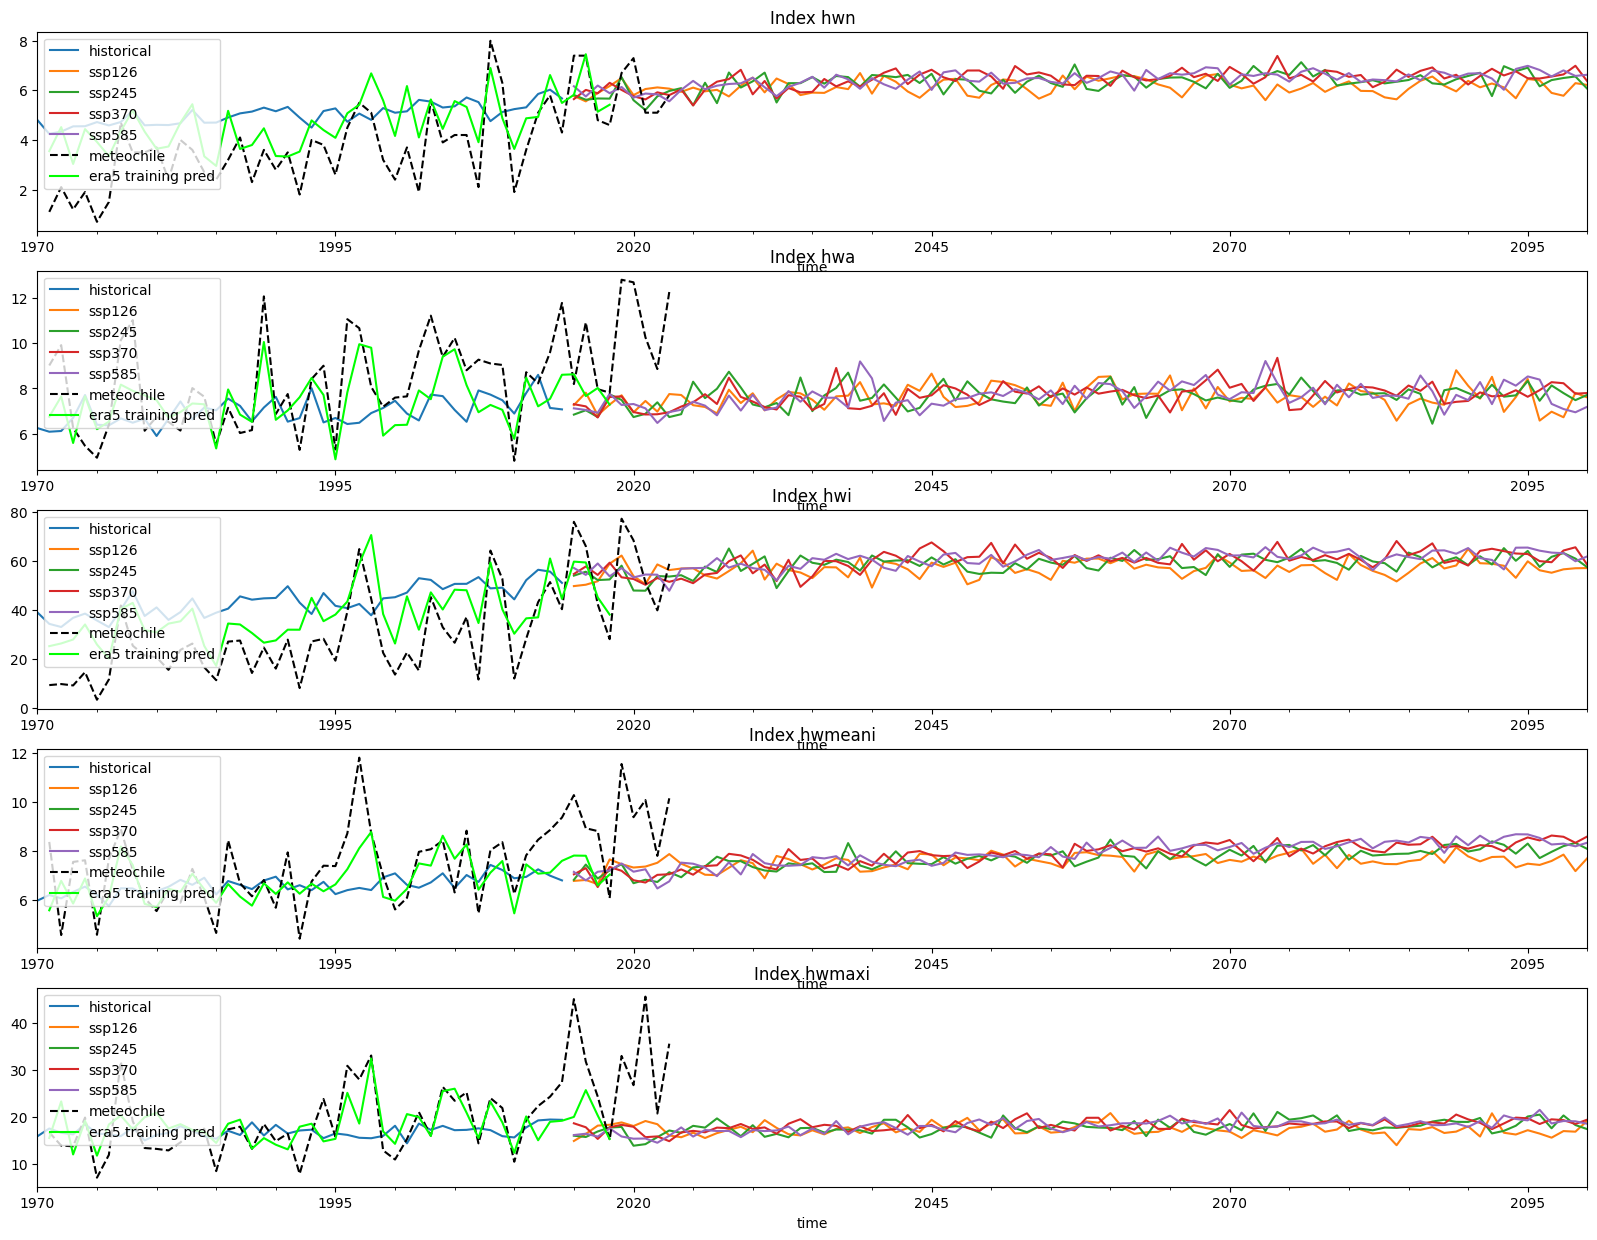

In [62]:
model = "mean"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 15))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")

### Mean Predictions vs Mean Detection

In [63]:
hw_mean_scenario = {}
models = list(hws_chile_model_scenario_yearly.keys())
for scenario in scenarios:
    
    all_models = pd.concat([hws_chile_model_scenario_yearly[model][scenario] for model in models], axis=1)
    df_mean_scenario = pd.DataFrame(columns=indices, index=hws_chile_model_scenario_yearly["EC-Earth3"][scenario].index)
    for index in indices:
        df_mean_scenario[index] = all_models[index].mean(axis=1)

    hw_mean_scenario[scenario] = df_mean_scenario

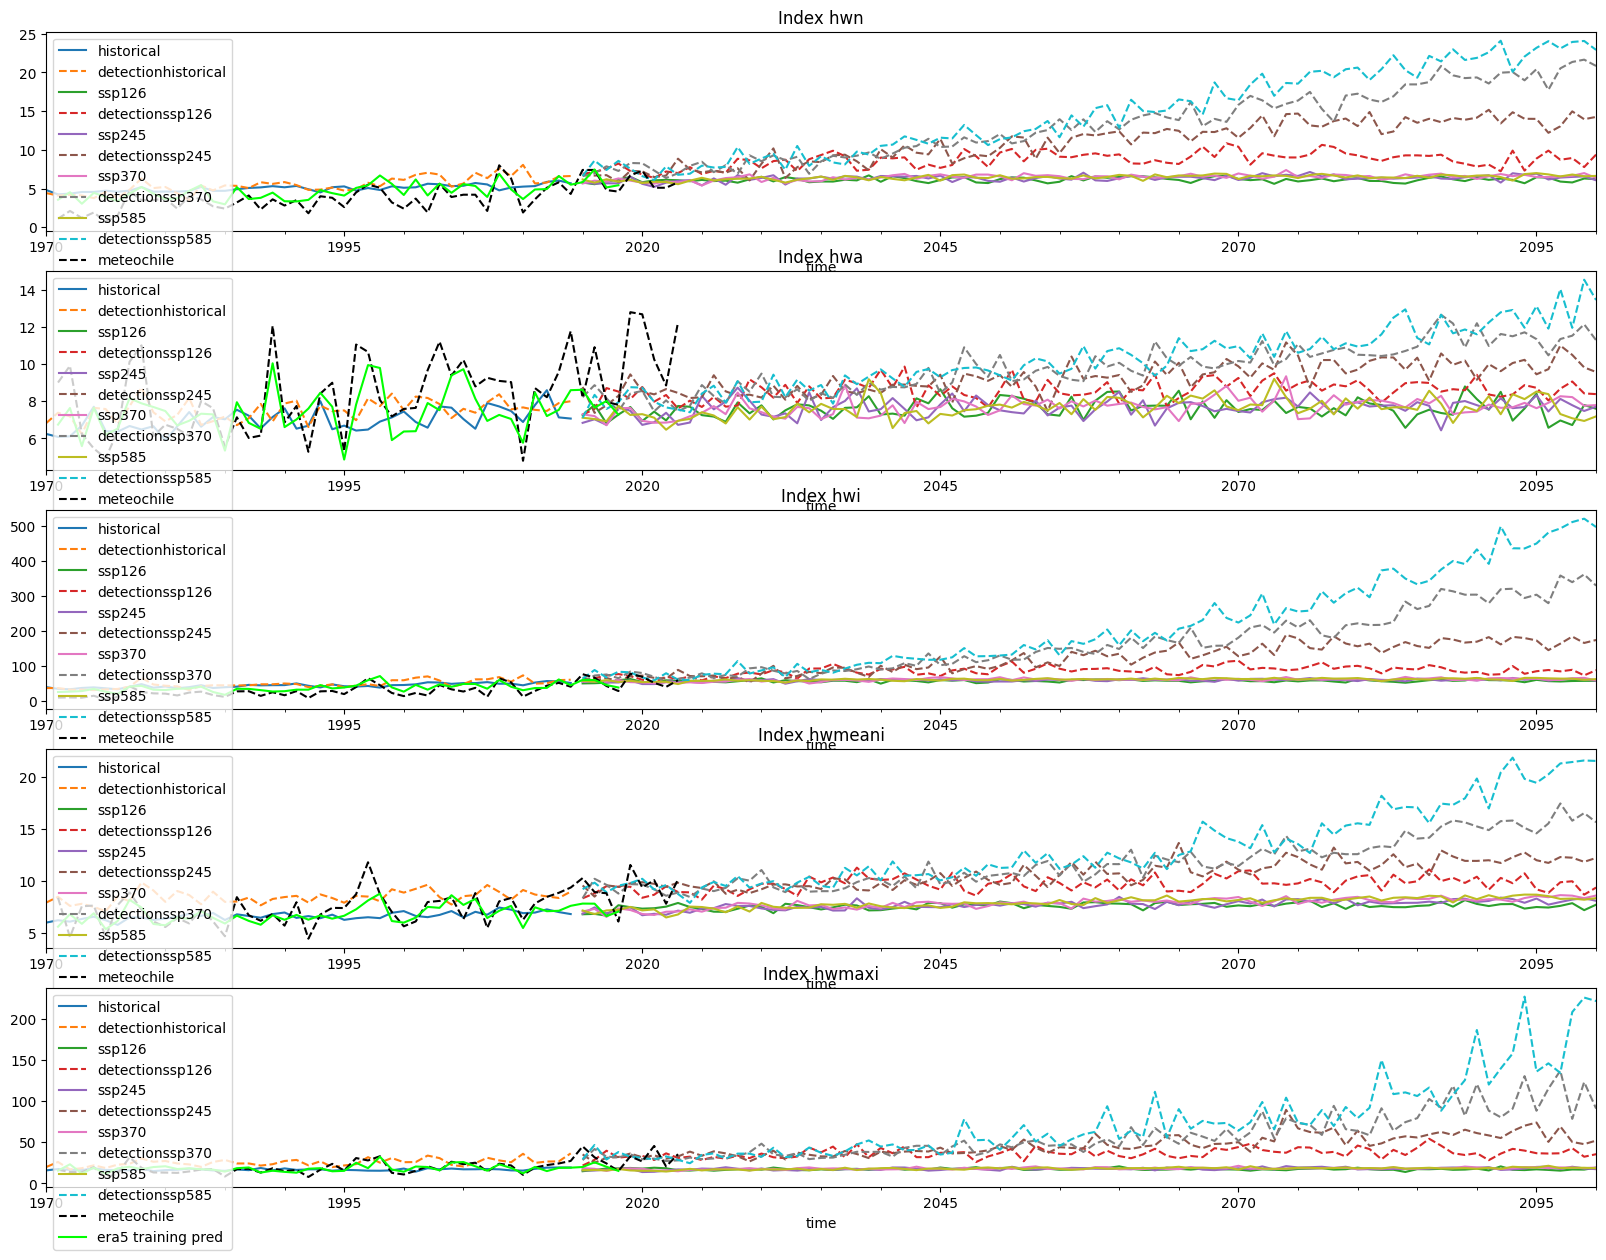

In [64]:
model = "mean"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(len(indices_of_interest), figsize=(20, 15))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
        values = hw_mean_scenario[scenario][index].values
        new_df = pd.DataFrame(values, columns=[index], index=df.index)
        # axs[i].plot(df.index, values, label=f"detection {scenario}")
        new_df.plot(y=index, ax=axs[i], label=f"detection{scenario}", linestyle="--")
    meteochile_yearly.plot(y=index, linestyle="--", label="meteochile", ax=axs[i], c="black")
    pred_train_yearly.plot(y=index, label="era5 training pred", ax=axs[i], c="lime")
    axs[i].set_title(f"Index {index}")
    axs[i].legend()